In [26]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from scipy import stats
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
from pytz import timezone
from collections import deque
import MySQLdb
import time
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import Queue
est = timezone('US/Eastern')

In [32]:
btc = pd.read_csv('binance-data.csv')
twitter_sent = pd.read_csv('live_tweet.csv')
reddit_sent = pd.read_csv('live_reddit.csv')

btc.columns = ["Price","Volume", "Number_Trades", "Market_Cap","Supply", "Stamp"]
twitter_sent.columns = ["Sentiment", "Stamp"]
reddit_sent.columns = ["Sentiment", "Stamp"]

merged = pd.merge(twitter_sent, btc,  on='Stamp', how='inner').merge(reddit_sent, on='Stamp', how='inner')
data = merged[["Sentiment_x", "Sentiment_y","Volume", "Market_Cap", "Supply", "Number_Trades", "Price"]].groupby(merged['Stamp']).mean()
datag = data[["Volume", "Market_Cap", "Supply", "Number_Trades", "Price"]]
tw_sentiment = data["Sentiment_x"]
rdt_sentiment = data["Sentiment_y"]

print "Dataset size: " + str(len(datag))
print "Timespan: " + str(len(datag)/60) + " hours"

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
values = datag.values.reshape(-1, datag.shape[1])
tw_sentiment = tw_sentiment.values.reshape(-1, 1)
rdt_sentiment = rdt_sentiment.values.reshape(-1, 1)
tw_sentiment = tw_sentiment.astype('float32')
rdt_sentiment = rdt_sentiment.astype('float32')
values = values.astype('float32')
scaled = scaler.fit_transform(values)

Dataset size: 11263
Timespan: 187 hours


7880
3375
Done


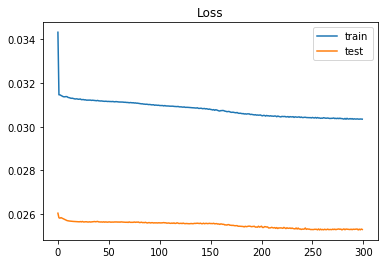

In [33]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
split = train_size

def create_dataset(dataset, look_back, tw_sentiment, rdt_sentiment, sent=False):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        if i >= look_back:
            a = dataset[i-look_back:i+1, 0]
            a = a.tolist()
            if(sent==True):                
                current_tw_sentiment = tw_sentiment[i].tolist()[0]
                current_rdt_sentiment = rdt_sentiment[i].tolist()[0]
                a.append(current_tw_sentiment)
                a.append(current_rdt_sentiment)
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

look_back = 2
trainX, trainY = create_dataset(train, look_back, tw_sentiment[0:train_size], rdt_sentiment[0:train_size], sent=True)
testX, testY = create_dataset(test, look_back, tw_sentiment[train_size:len(scaled)], rdt_sentiment[train_size:len(scaled)], sent=True)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Creating new model
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.save('models/LSTM_Philip_V3_{0}'.format(datetime.now()) + '.h5')

# Loading model
# model = load_model('models/LSTM_12-03-2018_GOOD.h5')

history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)
yhat = model.predict(testX)
# yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
# testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))
# rmse_sent = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print "Done"
# print 'Test RMSE: %.3f' % rmse_sent

pyplot.title("Loss")
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [34]:
#Enter the values for you database connection
dsn_database = "ai_datasets"         # e.g. "MySQLdbtest"
dsn_hostname = "127.0.0.1"      # e.g.: "mydbinstance.xyz.us-east-1.rds.amazonaws.com"
dsn_port = 3306                  # e.g. 3306 
dsn_uid = "root"             # e.g. "user1"
dsn_pwd = ""              # e.g. "Password123"


In [35]:
true_q = Queue.Queue()
pred_q = Queue.Queue()

def process_data(in_data):
    out_data = []
    for line in in_data:
        out_data.append(float(line.split(',')[0]))
    return np.array(out_data).reshape(-1,1)

def get_last_trade():
    conn = MySQLdb.connect(host=dsn_hostname, port=dsn_port, user=dsn_uid, passwd=dsn_pwd, db=dsn_database)
    cursor = conn.cursor()
    cursor.execute ("select * from trades order by date desc limit 1")
    return cursor.fetchone()
    

In [36]:
trades = []
diffs = deque([], maxlen=200)
lows = []
tops = []
last_trade = ()
top_lows = deque([], maxlen=30)
top_tops = deque([], maxlen=30)
bought = False
status = 0
to_db = False
prev = 8525
in_cooldown = False
minute_ = 0
current_decision = 0

while True:
    
    # Processing data
    minute_ = minute_ + 1
    btc = open('binance-data.csv','r')
    tw_sent = open('live_tweet.csv','r')
    rdt_sent = open('live_reddit.csv','r')
    bit_data = btc.readlines()
    tw_sent_data = tw_sent.readlines()
    rdt_sent_data = rdt_sent.readlines()
    bit_data = process_data(bit_data[len(bit_data)-5:])
    tw_sent_data = process_data(tw_sent_data[len(tw_sent_data)-5:])
    rdt_sent_data = process_data(rdt_sent_data[len(rdt_sent_data)-5:])
    
    # Last price recieved
    real_price = bit_data[len(bit_data) - 1][0]
    
    # Scaling prices
    live = scaler.fit_transform(bit_data)
    
    # Creating datasets and making prediction
    testX, testY = create_dataset(live, 2, tw_sent_data, rdt_sent_data, sent=True)
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    yhat = model.predict(testX)
    
    #Re scaling prices
    yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
    
    # Save real price and prediction price
    true_q.put(bit_data[4])
    pred_q.put(yhat_inverse[0])
    
    # Diference between real price and prediction
    alpha_diff = 100 * ((yhat_inverse[0][0] - float(real_price))/float(real_price))
    diffs.append(alpha_diff)
    diff_analisis = stats.describe(diffs)
    
    print "#######################################"
    print "In Cooldown ", in_cooldown
    print "#######################################"
    print "Minute: ", minute_
    print "#######################################"
    print "Diff analysis ", diff_analisis
    print "#######################################"
    print "########---> Initial values <---#######"
    print "#######################################"
    print "Pred: " + str(yhat_inverse[0][0])
    print "Real price: " + str(real_price)
    print "Diff: " + str(alpha_diff)

    
    
    if(len(diffs) >= 200):
        # Sorting all diffs
        sorted_diffs = sorted(diffs)
        # Taking the highest 75 (most negative)
        tops = sorted_diffs[0:75]
        # Taking the lowest 75 (most positive)
        lows = sorted_diffs[-75:]
        # Analyzing lists
        low_analisis = stats.describe(lows)
        top_analisis = stats.describe(tops)
        
        # Getting averages of tops and lows
        top_threshold = top_analisis.mean
        low_threshold = low_analisis.mean
        
        print "#######################################"
        print "########---> Averages (Phase 2) <---############"
        print "#######################################"
        print "Average low: " + str(low_threshold)
        print "Average top: " + str(top_threshold)
        print "#######################################"
        print "#######################################"
        print "Top analysis", top_analisis
        print "#######################################"
        print "#######################################"
        print "Low analysis", low_analisis
        print "#######################################"
        print "#######################################"
        print "Low length", len(top_lows)
        print "Top length", len(top_tops)
        print "#######################################"
        print "#######################################"
        print "Low break: ", alpha_diff > low_threshold
        print "#######################################"
        print "Top break: ", alpha_diff < top_threshold 
        
        # If diff is greater than the average low
        if(alpha_diff > low_threshold):
            # Adding to top_lows list
            top_lows.append(alpha_diff)
            # Sorting
            sorted_lows = sorted(top_lows)
            top_lows = deque(sorted_lows, maxlen=30)
            
        # If diff is lower than the average high
        if(alpha_diff < top_threshold):
            # Adding to top_tops list
            top_tops.append(alpha_diff)            
            # Sorting 
            sorted_tops = sorted(top_tops)
            top_tops = deque(sorted_tops, maxlen=30)
             
        if(len(top_tops) >= 30 and len(top_lows) >= 30):
            # Analyzing top_tops and top_lows
            alpha_top_analisis = stats.describe(top_tops)
            alpha_low_analisis = stats.describe(top_lows)

            # Getting averages of top_tops and top_lows analisis
            alpha_top = alpha_top_analisis.mean
            alpha_low = alpha_low_analisis.mean

            print "####################################"
            print "#######---> Signals (Phase 3) <---#######"
            print "Buy: " + str(alpha_top - alpha_top_analisis.variance)
            print "####################################"
            print "Sell: " + str(alpha_low)
            
            if(not in_cooldown):
                # If difference is lower that than the lowest top (negative value) -> BUY
                if alpha_diff < alpha_top - alpha_top_analisis.variance  and not bought:
                    decision = 1
                    print "Buy at: " + str(real_price)
                    bought = True
                    trades.append(("Buy", str(real_price)))
                    to_db = True
                    in_cooldown = True
                # If difference is greater than the average low in the top_lows list -> SELL
                elif alpha_diff > alpha_low and bought:
                    decision = 2
                    print "Sell at: " + str(real_price)
                    bought = False
                    trades.append(("Sold", str(real_price)))
                    to_db = True
                    in_cooldown = True
                else:
                    to_db = False
                    
                    # Saving decision to DB
                if to_db == True:
                    conn = MySQLdb.connect(host=dsn_hostname, port=dsn_port, user=dsn_uid, passwd=dsn_pwd, db=dsn_database)
                    cursor=conn.cursor()
                    input_string = "INSERT INTO live_data (yhat, bit_data, sent_data, reddit_sent, date, decision) values ({},{},{},{},'{}',{});".format(
                        yhat_inverse[0][0],
                        bit_data[0][0],
                        tw_sent_data[4][0],
                        rdt_sent_data[4][0],
                        datetime.now(tz=est).strftime('%Y-%m-%d %H:%M:%S'),
                        decision)
                    cursor.execute(input_string)
                    current_decision = cursor.lastrowid
                    conn.commit()
                    cursor.close()
                    to_db = False
            else:
                last_trade = get_last_trade()
                if len(last_trade) is not 0 and current_decision == last_trade[3]:
                    in_cooldown = False
                print "####################################"
                print "In Cooldown"
                print "####################################"
                print "Last trade", last_trade
                print "####################################"
                print "Current decision", current_decision
                print "####################################"

    time.sleep(60)

1
#######################################
In Cooldown  False
#######################################
Minute:  1
#######################################
Diff analysis  DescribeResult(nobs=1, minmax=(-0.20738340400868643, -0.20738340400868643), mean=-0.20738340400868643, variance=nan, skewness=0.0, kurtosis=-3.0)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8501.33
Real price: 8519.0
Diff: -0.207383404009
1
#######################################
In Cooldown  False
#######################################
Minute:  2
#######################################
Diff analysis  DescribeResult(nobs=2, minmax=(-0.25501936362591082, -0.20738340400868643), mean=-0.23120138381729863, variance=0.0011345923243269163, skewness=0.0, kurtosis=-2.0)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8509.7
Real price: 8531.46
Diff: -0.255019363626
1
####

1
#######################################
In Cooldown  False
#######################################
Minute:  17
#######################################
Diff analysis  DescribeResult(nobs=17, minmax=(-0.25501936362591082, 0.27978226701183434), mean=-0.022072669559547235, variance=0.023499247849854923, skewness=0.5142325597873214, kurtosis=-0.3015069258607843)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8467.13
Real price: 8466.04
Diff: 0.0128620494351
1
#######################################
In Cooldown  False
#######################################
Minute:  18
#######################################
Diff analysis  DescribeResult(nobs=18, minmax=(-0.25501936362591082, 0.27978226701183434), mean=-0.021875745723226828, variance=0.022117637174756236, skewness=0.5250291671130408, kurtosis=-0.14582493698761567)
#######################################
########---> Initial values <---#######
###################

1
#######################################
In Cooldown  False
#######################################
Minute:  33
#######################################
Diff analysis  DescribeResult(nobs=33, minmax=(-0.25501936362591082, 0.27978226701183434), mean=-0.042614618142762024, variance=0.018275687204154008, skewness=0.806374954885105, kurtosis=0.3981032595187006)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8446.48
Real price: 8456.19
Diff: -0.114775389389
1
#######################################
In Cooldown  False
#######################################
Minute:  34
#######################################
Diff analysis  DescribeResult(nobs=34, minmax=(-0.25501936362591082, 0.27978226701183434), mean=-0.042122208468251238, variance=0.017730122388774586, skewness=0.8067309298461236, kurtosis=0.48563162356645684)
#######################################
########---> Initial values <---#######
######################

1
#######################################
In Cooldown  False
#######################################
Minute:  49
#######################################
Diff analysis  DescribeResult(nobs=49, minmax=(-0.25501936362591082, 0.27978226701183434), mean=-0.037624669675565159, variance=0.015752957984255671, skewness=0.7112948138891416, kurtosis=0.35770476593727585)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8439.22
Real price: 8449.29
Diff: -0.119184847928
1
#######################################
In Cooldown  False
#######################################
Minute:  50
#######################################
Diff analysis  DescribeResult(nobs=50, minmax=(-0.36505107793146974, 0.27978226701183434), mean=-0.04417319784068325, variance=0.01757563010226872, skewness=0.4303685988866331, kurtosis=0.4870378598036833)
#######################################
########---> Initial values <---#######
#######################

1
#######################################
In Cooldown  False
#######################################
Minute:  65
#######################################
Diff analysis  DescribeResult(nobs=65, minmax=(-0.43965314703110153, 0.27978226701183434), mean=-0.050521622544917988, variance=0.018014942576962577, skewness=-0.009692519668870305, kurtosis=0.8961639194625546)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8451.35
Real price: 8450.02
Diff: 0.015781212648
1
#######################################
In Cooldown  False
#######################################
Minute:  66
#######################################
Diff analysis  DescribeResult(nobs=66, minmax=(-0.43965314703110153, 0.27978226701183434), mean=-0.05092855309444954, variance=0.017748718717401447, skewness=-0.0006511074051033963, kurtosis=0.9511952575722229)
#######################################
########---> Initial values <---#######
#################

1
#######################################
In Cooldown  False
#######################################
Minute:  81
#######################################
Diff analysis  DescribeResult(nobs=81, minmax=(-0.43965314703110153, 0.27978226701183434), mean=-0.036708920998411214, variance=0.017883210041155041, skewness=-0.057222697048676406, kurtosis=0.5957898083985476)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8388.36
Real price: 8403.64
Diff: -0.181810166487
1
#######################################
In Cooldown  False
#######################################
Minute:  82
#######################################
Diff analysis  DescribeResult(nobs=82, minmax=(-0.50291071640418783, 0.27978226701183434), mean=-0.042394308747262147, variance=0.020312967646368897, skewness=-0.36095975863310237, kurtosis=1.1154099579210968)
#######################################
########---> Initial values <---#######
#################

1
#######################################
In Cooldown  False
#######################################
Minute:  97
#######################################
Diff analysis  DescribeResult(nobs=97, minmax=(-0.50291071640418783, 0.27978226701183434), mean=-0.046067821973003478, variance=0.020176797148380787, skewness=-0.4953907060673831, kurtosis=1.2375660006393119)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8406.4
Real price: 8404.0
Diff: 0.0285159968467
1
#######################################
In Cooldown  False
#######################################
Minute:  98
#######################################
Diff analysis  DescribeResult(nobs=98, minmax=(-0.50291071640418783, 0.27978226701183434), mean=-0.044796200827241783, variance=0.020127256923514376, skewness=-0.5120742974228106, kurtosis=1.2382700348181652)
#######################################
########---> Initial values <---#######
######################

1
#######################################
In Cooldown  False
#######################################
Minute:  113
#######################################
Diff analysis  DescribeResult(nobs=113, minmax=(-0.50291071640418783, 0.27978226701183434), mean=-0.048827391582464991, variance=0.020909858440693676, skewness=-0.6442769037549304, kurtosis=1.3192264091879862)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8392.78
Real price: 8399.74
Diff: -0.0828215739416
1
#######################################
In Cooldown  False
#######################################
Minute:  114
#######################################
Diff analysis  DescribeResult(nobs=114, minmax=(-0.50291071640418783, 0.27978226701183434), mean=-0.047931294253926199, variance=0.020816356353775729, skewness=-0.6584175549885193, kurtosis=1.3376496260253736)
#######################################
########---> Initial values <---#######
###############

1
#######################################
In Cooldown  False
#######################################
Minute:  129
#######################################
Diff analysis  DescribeResult(nobs=129, minmax=(-0.50291071640418783, 0.27978226701183434), mean=-0.060455890581405429, variance=0.021124319712220875, skewness=-0.4923251916676371, kurtosis=0.7962271261842297)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8441.4
Real price: 8443.89
Diff: -0.0295072827808
1
#######################################
In Cooldown  False
#######################################
Minute:  130
#######################################
Diff analysis  DescribeResult(nobs=130, minmax=(-0.50291071640418783, 0.27978226701183434), mean=-0.059083725844192199, variance=0.021205333984433767, skewness=-0.4997717932724487, kurtosis=0.7738109024615407)
#######################################
########---> Initial values <---#######
################

1
#######################################
In Cooldown  False
#######################################
Minute:  145
#######################################
Diff analysis  DescribeResult(nobs=145, minmax=(-0.50291071640418783, 0.27978226701183434), mean=-0.054092181231788952, variance=0.020266124873352727, skewness=-0.5090268471187397, kurtosis=0.8882765969345399)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8409.99
Real price: 8411.07
Diff: -0.0128954869892
1
#######################################
In Cooldown  False
#######################################
Minute:  146
#######################################
Diff analysis  DescribeResult(nobs=146, minmax=(-0.50291071640418783, 0.27978226701183434), mean=-0.053150693062643722, variance=0.020255772890921314, skewness=-0.519571414885043, kurtosis=0.8847982358563153)
#######################################
########---> Initial values <---#######
################

1
#######################################
In Cooldown  False
#######################################
Minute:  161
#######################################
Diff analysis  DescribeResult(nobs=161, minmax=(-1.1842470105182747, 0.27978226701183434), mean=-0.076997362216848123, variance=0.036559862050455118, skewness=-1.9181177490758448, kurtosis=7.557764731417507)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8479.6
Real price: 8519.0
Diff: -0.4625460368
1
#######################################
In Cooldown  False
#######################################
Minute:  162
#######################################
Diff analysis  DescribeResult(nobs=162, minmax=(-1.1842470105182747, 0.27978226701183434), mean=-0.078233223687536504, variance=0.036580213441049572, skewness=-1.8922778767884014, kurtosis=7.438304069532437)
#######################################
########---> Initial values <---#######
########################

1
#######################################
In Cooldown  False
#######################################
Minute:  177
#######################################
Diff analysis  DescribeResult(nobs=177, minmax=(-1.1842470105182747, 0.27978226701183434), mean=-0.075749200399130731, variance=0.03416545107606879, skewness=-1.9484028983502633, kurtosis=8.058429540895016)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8500.36
Real price: 8501.01
Diff: -0.00768796516532
1
#######################################
In Cooldown  False
#######################################
Minute:  178
#######################################
Diff analysis  DescribeResult(nobs=178, minmax=(-1.1842470105182747, 0.27978226701183434), mean=-0.075740086143661442, variance=0.033972440715144554, skewness=-1.954046595333186, kurtosis=8.121284441707706)
#######################################
########---> Initial values <---#######
####################

1
#######################################
In Cooldown  False
#######################################
Minute:  193
#######################################
Diff analysis  DescribeResult(nobs=193, minmax=(-1.1842470105182747, 0.27978226701183434), mean=-0.070791363497941781, variance=0.032330951176615344, skewness=-1.9904050516694562, kurtosis=8.569829554195156)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8475.52
Real price: 8478.0
Diff: -0.0292001172151
1
#######################################
In Cooldown  False
#######################################
Minute:  194
#######################################
Diff analysis  DescribeResult(nobs=194, minmax=(-1.1842470105182747, 0.27978226701183434), mean=-0.070814491045792849, variance=0.032163537062264332, skewness=-1.9951574289957301, kurtosis=8.628669891066329)
#######################################
########---> Initial values <---#######
####################

1
#######################################
In Cooldown  False
#######################################
Minute:  203
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1842470105182747, 0.27978226701183434), mean=-0.070936066438749265, variance=0.031847704301783873, skewness=-1.9829726854775949, kurtosis=8.531787803326356)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8499.07
Real price: 8498.0
Diff: 0.0125948752648
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0726433896529
Average top: -0.23259171893
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1842470105182747, -0.081755779815163646), mean=-0.23259171892999836, variance=0.032108508833636723, skewness=-2.827367848557652, kurtosis=10.43607526

1
#######################################
In Cooldown  False
#######################################
Minute:  209
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1842470105182747, 0.27978226701183434), mean=-0.071301905700032794, variance=0.031763432080242175, skewness=-1.9857449720230376, kurtosis=8.575848801447012)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8495.18
Real price: 8504.04
Diff: -0.104132032393
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.072013909327
Average top: -0.232147767446
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1842470105182747, -0.081755779815163646), mean=-0.23214776744584972, variance=0.032208928436719589, skewness=-2.818665900483586, kurtosis=10.3829781

1
#######################################
In Cooldown  False
#######################################
Minute:  215
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1842470105182747, 0.27978226701183434), mean=-0.07598600706256961, variance=0.031349862748651924, skewness=-2.0033214707579226, kurtosis=8.59705111466897)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8518.15
Real price: 8513.74
Diff: 0.0518490918797
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0670309000154
Average top: -0.237252011552
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1842470105182747, -0.083683686468769322), mean=-0.23725201155186046, variance=0.031557954736709269, skewness=-2.8364494523523094, kurtosis=10.5935354

1
#######################################
In Cooldown  False
#######################################
Minute:  221
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1842470105182747, 0.25718934127570048), mean=-0.075760791925392645, variance=0.030876687155592684, skewness=-2.0859035675126067, kurtosis=8.886449504843247)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8514.92
Real price: 8507.01
Diff: 0.0929467837407
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0657455779803
Average top: -0.235505686501
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1842470105182747, -0.083072788319360616), mean=-0.23550568650123097, variance=0.031905635201486759, skewness=-2.8092910893323, kurtosis=10.41850202

1
#######################################
In Cooldown  False
#######################################
Minute:  227
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1842470105182747, 0.25718934127570048), mean=-0.081138309333336503, variance=0.032338725739097483, skewness=-2.0702963462612716, kurtosis=8.086890635100652)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8516.97
Real price: 8550.0
Diff: -0.386353252924
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0623359556096
Average top: -0.24526616707
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1842470105182747, -0.083072788319360616), mean=-0.24526616706981652, variance=0.034084095203804926, skewness=-2.550249050270037, kurtosis=8.536728517

1
#######################################
In Cooldown  False
#######################################
Minute:  233
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1842470105182747, 0.25718934127570048), mean=-0.085144975157732172, variance=0.033636506060201833, skewness=-1.958474814334365, kurtosis=7.214700915183888)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8561.42
Real price: 8565.94
Diff: -0.0527338323348
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0623404575612
Average top: -0.255454675603
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1842470105182747, -0.083072788319360616), mean=-0.25545467560269303, variance=0.034148668950728191, skewness=-2.422041428442351, kurtosis=7.9612435

1
#######################################
In Cooldown  False
#######################################
Minute:  239
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1842470105182747, 0.25718934127570048), mean=-0.083850702087354845, variance=0.033583023605492167, skewness=-1.9835260955476606, kurtosis=7.3027671777230925)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8565.45
Real price: 8580.17
Diff: -0.171521951197
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0623404575612
Average top: -0.252948972645
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1842470105182747, -0.081755779815163646), mean=-0.25294897264497335, variance=0.034836510215940239, skewness=-2.3684259259203797, kurtosis=7.68339

1
#######################################
In Cooldown  False
#######################################
Minute:  245
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1842470105182747, 0.28987113863575992), mean=-0.084400156366228524, variance=0.033879771656709932, skewness=-1.9299268154105649, kurtosis=7.153615758460971)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8544.38
Real price: 8544.99
Diff: -0.00716291432172
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.062827688438
Average top: -0.254686319867
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1842470105182747, -0.082821573941571788), mean=-0.25468631986731749, variance=0.034460005899749881, skewness=-2.3896051268046183, kurtosis=7.81765

1
#######################################
In Cooldown  False
#######################################
Minute:  251
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1842470105182747, 0.28987113863575992), mean=-0.082131127918230351, variance=0.033011581976546758, skewness=-1.9999880645274801, kurtosis=7.697673660706512)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8538.43
Real price: 8564.39
Diff: -0.303073613532
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0622757220915
Average top: -0.248654281233
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1842470105182747, -0.081755779815163646), mean=-0.2486542812329337, variance=0.034365378330169123, skewness=-2.46578648008865, kurtosis=8.194442356

1
#######################################
In Cooldown  False
#######################################
Minute:  257
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1842470105182747, 0.28987113863575992), mean=-0.082043967223670064, variance=0.033189446805542915, skewness=-1.9897250507742221, kurtosis=7.593061803722364)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8563.69
Real price: 8563.05
Diff: 0.00744477726979
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0624757689088
Average top: -0.249835594381
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1842470105182747, -0.081755779815163646), mean=-0.24983559438092315, variance=0.034306900798780723, skewness=-2.454142600035855, kurtosis=8.168631

1
#######################################
In Cooldown  False
#######################################
Minute:  263
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1842470105182747, 0.28987113863575992), mean=-0.081752440337248447, variance=0.033250706004286576, skewness=-1.9871400773550272, kurtosis=7.568557240552863)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8552.24
Real price: 8556.7
Diff: -0.0521772229656
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.063076093104
Average top: -0.249835594381
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1842470105182747, -0.081755779815163646), mean=-0.24983559438092315, variance=0.034306900798780723, skewness=-2.454142600035855, kurtosis=8.16863195

1
#######################################
In Cooldown  False
#######################################
Minute:  269
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1842470105182747, 0.28987113863575992), mean=-0.085155460707079592, variance=0.033553589567771748, skewness=-1.9138615769821778, kurtosis=7.2410305095283345)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8563.13
Real price: 8579.21
Diff: -0.187476742468
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0627582070789
Average top: -0.257063922459
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1842470105182747, -0.083072788319360616), mean=-0.25706392245872473, variance=0.03278155694959814, skewness=-2.5515817608223346, kurtosis=8.770162

1
#######################################
In Cooldown  False
#######################################
Minute:  275
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1842470105182747, 0.28987113863575992), mean=-0.097473064014703362, variance=0.036608844511239039, skewness=-1.7583851220302542, kurtosis=5.8454526789989565)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8610.99
Real price: 8625.0
Diff: -0.162386775362
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0583007382962
Average top: -0.28038957298
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1842470105182747, -0.089791192825452712), mean=-0.28038957297953482, variance=0.034137181936256492, skewness=-2.3104070093249427, kurtosis=7.0528450

1
#######################################
In Cooldown  False
#######################################
Minute:  281
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1842470105182747, 0.28987113863575992), mean=-0.098158466689927421, variance=0.035878102403839318, skewness=-1.8394673018883785, kurtosis=6.115035042592213)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8603.45
Real price: 8596.06
Diff: 0.0860059725037
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0542311263267
Average top: -0.279135943191
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1842470105182747, -0.087787932312410374), mean=-0.27913594319053531, variance=0.034505555227198802, skewness=-2.2807596336558347, kurtosis=6.915796

1
#######################################
In Cooldown  False
#######################################
Minute:  287
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1842470105182747, 0.28987113863575992), mean=-0.089796942939287056, variance=0.034877851479264615, skewness=-1.9435113019867258, kurtosis=6.8338392799722545)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8593.61
Real price: 8584.0
Diff: 0.111911059092
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0591933936348
Average top: -0.264999749269
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1842470105182747, -0.086656781964376317), mean=-0.26499974926891534, variance=0.035151710583900722, skewness=-2.356866157963688, kurtosis=7.25791512

1
#######################################
In Cooldown  False
#######################################
Minute:  293
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1842470105182747, 0.28987113863575992), mean=-0.090667514457829265, variance=0.034786797990155806, skewness=-1.9412061839429153, kurtosis=6.84364383520537)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8576.54
Real price: 8570.78
Diff: 0.0672511173137
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0583503277346
Average top: -0.266013675381
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1842470105182747, -0.087787932312410374), mean=-0.26601367538132137, variance=0.034815251327586033, skewness=-2.387482737231139, kurtosis=7.38958472

1
#######################################
In Cooldown  False
#######################################
Minute:  299
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1842470105182747, 0.28987113863575992), mean=-0.091341313845312744, variance=0.035215134007397488, skewness=-1.8785609601179825, kurtosis=6.615663643868508)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8548.89
Real price: 8569.99
Diff: -0.24624627625
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0602851908956
Average top: -0.2681264533
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1842470105182747, -0.089791192825452712), mean=-0.26812645330048968, variance=0.03438675872333969, skewness=-2.409896618832402, kurtosis=7.52708373927

1
#######################################
In Cooldown  False
#######################################
Minute:  305
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1842470105182747, 0.28987113863575992), mean=-0.096324435553451646, variance=0.035030968574273028, skewness=-1.8417320415426832, kurtosis=6.511182320286959)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8575.21
Real price: 8573.01
Diff: 0.0256045207576
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0555837985443
Average top: -0.273788521862
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1842470105182747, -0.093628001620506773), mean=-0.27378852186237851, variance=0.033414072402975413, skewness=-2.45006055908553, kurtosis=7.81125279

1
#######################################
In Cooldown  False
#######################################
Minute:  311
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1842470105182747, 0.28987113863575992), mean=-0.089343973180014788, variance=0.034681863632911189, skewness=-1.893404691334736, kurtosis=6.909196599095623)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8558.47
Real price: 8540.33
Diff: 0.212457942199
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0609150888412
Average top: -0.26359298659
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1842470105182747, -0.087171730610918943), mean=-0.26359298658956759, variance=0.034093111561849576, skewness=-2.473479635440965, kurtosis=7.9342286215

1
#######################################
In Cooldown  False
#######################################
Minute:  317
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1842470105182747, 0.28987113863575992), mean=-0.083185520536876292, variance=0.0362847734952991, skewness=-1.7948530222563392, kurtosis=6.385775951471519)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8504.98
Real price: 8491.53
Diff: 0.158387147987
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0723634016714
Average top: -0.262136346896
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1842470105182747, -0.086656781964376317), mean=-0.26213634689632115, variance=0.034452106013302959, skewness=-2.4474972193246054, kurtosis=7.795583380

1
#######################################
In Cooldown  False
#######################################
Minute:  323
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1842470105182747, 0.28987113863575992), mean=-0.07791714773906272, variance=0.035859971129102115, skewness=-1.8910242604297431, kurtosis=6.810085849524782)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8490.9
Real price: 8500.0
Diff: -0.107019761029
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0742189069899
Average top: -0.252630713589
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1842470105182747, -0.083072788319360616), mean=-0.25263071358857564, variance=0.036119841336081621, skewness=-2.389789991924535, kurtosis=7.3271618869

1
#######################################
In Cooldown  False
#######################################
Minute:  329
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1842470105182747, 0.28987113863575992), mean=-0.076375252002107319, variance=0.035956616877500729, skewness=-1.902886456675722, kurtosis=6.820628756659387)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8499.13
Real price: 8502.01
Diff: -0.0338642347515
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0756102020236
Average top: -0.25174846235
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1842470105182747, -0.081755779815163646), mean=-0.25174846234976633, variance=0.036255556973590633, skewness=-2.3878513487698942, kurtosis=7.2961011

1
#######################################
In Cooldown  False
#######################################
Minute:  335
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1842470105182747, 0.28987113863575992), mean=-0.076626505363937086, variance=0.035792743682812059, skewness=-1.9141254380359645, kurtosis=6.9000865999576)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8484.16
Real price: 8485.0
Diff: -0.00995552813789
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0741655160907
Average top: -0.250657953157
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1842470105182747, -0.079363144838991359), mean=-0.25065795315680245, variance=0.036545011937265962, skewness=-2.3682393461757103, kurtosis=7.1962159

1
#######################################
In Cooldown  False
#######################################
Minute:  341
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1842470105182747, 0.28987113863575992), mean=-0.07799506242533584, variance=0.035623919406229679, skewness=-1.9087908240797522, kurtosis=6.935996537255255)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8475.23
Real price: 8482.2
Diff: -0.0821550386397
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0728010652787
Average top: -0.250774178233
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1842470105182747, -0.083072788319360616), mean=-0.2507741782325158, variance=0.036470354293571421, skewness=-2.3771848174721084, kurtosis=7.22748150

1
#######################################
In Cooldown  False
#######################################
Minute:  347
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1842470105182747, 0.28987113863575992), mean=-0.083462399441701793, variance=0.035837569118198971, skewness=-1.838062914811144, kurtosis=6.609457012788003)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8476.92
Real price: 8492.01
Diff: -0.177639867505
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0700451471175
Average top: -0.259095813454
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1842470105182747, -0.087787932312410374), mean=-0.2590958134543131, variance=0.035210726885041593, skewness=-2.408035290212453, kurtosis=7.498406555

1
#######################################
In Cooldown  False
#######################################
Minute:  353
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-1.1842470105182747, 0.28987113863575992), mean=-0.085028411844220844, variance=0.035262838985433989, skewness=-1.8928728015318366, kurtosis=6.806804844251909)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8495.26
Real price: 8494.99
Diff: 0.00314109772348
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0655405920684
Average top: -0.259112614211
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-1.1842470105182747, -0.083596409004227268), mean=-0.25911261421110499, variance=0.035400816180693649, skewness=-2.3794447516153094, kurtosis=7.39602

1
#######################################
In Cooldown  False
#######################################
Minute:  359
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70909823063320387, 0.28987113863575992), mean=-0.067182605455573793, variance=0.023434952254434805, skewness=-0.988292586662599, kurtosis=2.037836230301422)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8486.92
Real price: 8475.0
Diff: 0.140694137168
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0676845876891
Average top: -0.216446917302
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70909823063320387, -0.082155038639748254), mean=-0.2164469173016462, variance=0.016842424387155698, skewness=-1.5207816184118355, kurtosis=2.64996526

1
#######################################
In Cooldown  False
#######################################
Minute:  365
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70909823063320387, 0.28987113863575992), mean=-0.067524575168126558, variance=0.023224613168976258, skewness=-0.9974945232917392, kurtosis=2.2090932804296184)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8496.17
Real price: 8542.04
Diff: -0.537014943152
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0675960304576
Average top: -0.215556347052
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70909823063320387, -0.082389579721941525), mean=-0.21555634705213678, variance=0.016646939150707876, skewness=-1.6456600256202232, kurtosis=3.077

1
#######################################
In Cooldown  False
#######################################
Minute:  371
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70909823063320387, 0.28987113863575992), mean=-0.075088912712279909, variance=0.024129735408531052, skewness=-0.9048649197723434, kurtosis=1.8010477771003872)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8536.43
Real price: 8547.72
Diff: -0.1321085111
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0648386200975
Average top: -0.227949766986
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70909823063320387, -0.087787932312410374), mean=-0.22794976698557642, variance=0.016186328321590747, skewness=-1.553776648782784, kurtosis=2.770048

1
#######################################
In Cooldown  False
#######################################
Minute:  377
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70909823063320387, 0.28987113863575992), mean=-0.071421572119659729, variance=0.025014980772151394, skewness=-0.8783569727353463, kurtosis=1.6275701352800729)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8521.28
Real price: 8510.0
Diff: 0.132576105317
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0722721096575
Average top: -0.227940092566
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70909823063320387, -0.086656781964376317), mean=-0.22794009256576384, variance=0.016303703079049266, skewness=-1.5248173024606635, kurtosis=2.70434

1
#######################################
In Cooldown  False
#######################################
Minute:  383
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70909823063320387, 0.28987113863575992), mean=-0.076412446559794636, variance=0.024498511180068707, skewness=-0.852198284186057, kurtosis=1.6645296234316795)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8523.37
Real price: 8529.99
Diff: -0.0775957093736
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0660086507154
Average top: -0.231137153656
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70909823063320387, -0.089791192825452712), mean=-0.2311371536563494, variance=0.015726786661382615, skewness=-1.5777212991007077, kurtosis=2.9102

1
#######################################
In Cooldown  False
#######################################
Minute:  389
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70909823063320387, 0.28987113863575992), mean=-0.072747696757977126, variance=0.024953944749343523, skewness=-0.8766696487012444, kurtosis=1.5966745523162293)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8505.88
Real price: 8517.97
Diff: -0.141948066852
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.071172864942
Average top: -0.23019661337
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70909823063320387, -0.084113660319312777), mean=-0.23019661337047134, variance=0.015934251863812889, skewness=-1.5511502736262042, kurtosis=2.82769

1
#######################################
In Cooldown  False
#######################################
Minute:  395
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70909823063320387, 0.28987113863575992), mean=-0.076971000118379734, variance=0.025241237471155167, skewness=-0.8191774867982661, kurtosis=1.429636962212137)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8530.19
Real price: 8538.59
Diff: -0.0983604289467
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0690860657343
Average top: -0.236243815603
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70909823063320387, -0.094060202205882348), mean=-0.2362438156028468, variance=0.015370034719030645, skewness=-1.5418603288074821, kurtosis=2.8887

1
#######################################
In Cooldown  False
#######################################
Minute:  401
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70909823063320387, 0.28987113863575992), mean=-0.073464468381844436, variance=0.024840077313508575, skewness=-0.850784683955199, kurtosis=1.6106611684572938)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8517.34
Real price: 8524.0
Diff: -0.0780883388081
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0710799930675
Average top: -0.229866369
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70909823063320387, -0.092617391778036032), mean=-0.22986636900047344, variance=0.015658514943529999, skewness=-1.6116858333857509, kurtosis=3.0168370

/home/thriven/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:166: Warning:

Data truncated for column 'date' at row 1



1
#######################################
In Cooldown  True
#######################################
Minute:  405
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70909823063320387, 0.28987113863575992), mean=-0.078725192087416698, variance=0.026193322976723079, skewness=-0.8522562589568526, kurtosis=1.5172274454638943)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8527.29
Real price: 8550.04
Diff: -0.266068747924
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0699788589588
Average top: -0.239371513381
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70909823063320387, -0.095858825468933179), mean=-0.2393715133813285, variance=0.016563075667073105, skewness=-1.5737618996018368, kurtosis=2.56461

1
#######################################
In Cooldown  False
#######################################
Minute:  410
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70909823063320387, 0.28987113863575992), mean=-0.079716387316259935, variance=0.026142729558673455, skewness=-0.8377930881850759, kurtosis=1.5133188743053418)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8549.84
Real price: 8558.0
Diff: -0.0953055620472
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0694594897196
Average top: -0.239588645277
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70909823063320387, -0.098360428946701342), mean=-0.23958864527721355, variance=0.016515529158598333, skewness=-1.5793836659820872, kurtosis=2.580

1
#######################################
In Cooldown  False
#######################################
Minute:  415
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70909823063320387, 0.28987113863575992), mean=-0.075469682471939081, variance=0.026062960669523835, skewness=-0.8898916444797378, kurtosis=1.6319046172848086)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8545.38
Real price: 8546.89
Diff: -0.0176571902177
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0724992921408
Average top: -0.233811740011
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70909823063320387, -0.094501152853442877), mean=-0.23381174001067714, variance=0.017296198212156146, skewness=-1.552684612973236, kurtosis=2.410

1
#######################################
In Cooldown  False
#######################################
Minute:  420
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70909823063320387, 0.28987113863575992), mean=-0.076042437346274042, variance=0.026252063255059296, skewness=-0.8662461152200442, kurtosis=1.564887835437328)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8540.56
Real price: 8530.04
Diff: 0.123312361372
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0731673267822
Average top: -0.235421875163
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70909823063320387, -0.095858825468933179), mean=-0.23542187516341403, variance=0.017024322987665891, skewness=-1.5705166588245703, kurtosis=2.48658

1
#######################################
In Cooldown  False
#######################################
Minute:  425
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70909823063320387, 0.28987113863575992), mean=-0.073174215151565428, variance=0.02647168934541394, skewness=-0.8946758794369167, kurtosis=1.5653437719485694)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8525.86
Real price: 8523.97
Diff: 0.0221654346508
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0758188891132
Average top: -0.233809283467
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70909823063320387, -0.094501152853442877), mean=-0.2338092834674059, variance=0.017358604414381095, skewness=-1.5379210474013703, kurtosis=2.38079

1
#######################################
In Cooldown  False
#######################################
Minute:  430
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70909823063320387, 0.28987113863575992), mean=-0.066528614668114064, variance=0.023426926372823217, skewness=-0.7971657831871606, kurtosis=1.6099590506098371)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8532.97
Real price: 8546.13
Diff: -0.154013881868
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0758188891132
Average top: -0.217663939978
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70909823063320387, -0.092617391778036032), mean=-0.2176639399779719, variance=0.014248731484717041, skewness=-1.718180399216579, kurtosis=3.61438

1
#######################################
In Cooldown  False
#######################################
Minute:  435
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70909823063320387, 0.28987113863575992), mean=-0.067305569486595718, variance=0.023404800838116052, skewness=-0.7855755686500872, kurtosis=1.6007776782776384)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8547.45
Real price: 8546.13
Diff: 0.0154478730431
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0752260031395
Average top: -0.218250176733
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70909823063320387, -0.094501152853442877), mean=-0.21825017673336455, variance=0.014122897368719819, skewness=-1.7383802204680847, kurtosis=3.683

1
#######################################
In Cooldown  False
#######################################
Minute:  440
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70909823063320387, 0.28987113863575992), mean=-0.066056469255079311, variance=0.023265210556509465, skewness=-0.8110903594524894, kurtosis=1.6773227971307572)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8547.33
Real price: 8555.0
Diff: -0.089642844097
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.075271603763
Average top: -0.215624827684
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70909823063320387, -0.092617391778036032), mean=-0.21562482768398017, variance=0.014507599090280337, skewness=-1.7059813243955602, kurtosis=3.51178

1
#######################################
In Cooldown  False
#######################################
Minute:  445
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70909823063320387, 0.23152308158256216), mean=-0.068989774695166262, variance=0.022498325022258504, skewness=-0.8658353773938473, kurtosis=1.7677919133294138)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8549.38
Real price: 8555.0
Diff: -0.0657396076856
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0697705668903
Average top: -0.215639930588
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70909823063320387, -0.093750109572355522), mean=-0.21563993058790445, variance=0.014503850448649325, skewness=-1.70666079088041, kurtosis=3.51374

1
#######################################
In Cooldown  False
#######################################
Minute:  450
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70909823063320387, 0.26341199457268488), mean=-0.066683444740958941, variance=0.023233604990156722, skewness=-0.8062792365030838, kurtosis=1.6485117794128596)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8540.48
Real price: 8518.04
Diff: 0.263411994573
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0751576470052
Average top: -0.215639930588
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70909823063320387, -0.093750109572355522), mean=-0.21563993058790445, variance=0.014503850448649325, skewness=-1.70666079088041, kurtosis=3.513747

1
#######################################
In Cooldown  False
#######################################
Minute:  455
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70909823063320387, 0.26341199457268488), mean=-0.06385902715431041, variance=0.022795340747384957, skewness=-0.831925964235402, kurtosis=1.8458005128265391)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8515.38
Real price: 8527.38
Diff: -0.140758906898
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0767959155286
Average top: -0.20974641888
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70909823063320387, -0.093750109572355522), mean=-0.20974641888015097, variance=0.014599795172518781, skewness=-1.8121233557643506, kurtosis=3.779983

1
#######################################
In Cooldown  False
#######################################
Minute:  460
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70909823063320387, 0.26341199457268488), mean=-0.065986849820982171, variance=0.022701885706221357, skewness=-0.7977308799045058, kurtosis=1.8381505536510039)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8529.68
Real price: 8536.99
Diff: -0.0856424695648
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0751330687818
Average top: -0.210309795924
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70909823063320387, -0.094501152853442877), mean=-0.2103097959235008, variance=0.014481275878344115, skewness=-1.830947779896149, kurtosis=3.8442

1
#######################################
In Cooldown  False
#######################################
Minute:  465
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70909823063320387, 0.26341199457268488), mean=-0.062778863047546096, variance=0.02311846258440426, skewness=-0.7918822868420351, kurtosis=1.8153993010816958)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8503.63
Real price: 8483.0
Diff: 0.243156349464
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0794074427365
Average top: -0.208234798227
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70909823063320387, -0.093750109572355522), mean=-0.20823479822677537, variance=0.014799418358389382, skewness=-1.801001432992259, kurtosis=3.6976594

1
#######################################
In Cooldown  False
#######################################
Minute:  470
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.70909823063320387, 0.26341199457268488), mean=-0.061090948643426873, variance=0.023128296901259789, skewness=-0.8177582174229003, kurtosis=1.842791591628007)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8501.07
Real price: 8501.0
Diff: 0.000804133337254
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0806751751718
Average top: -0.206952124935
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.70909823063320387, -0.089642844097019281), mean=-0.20695212493470003, variance=0.014979067990568798, skewness=-1.7813707850306724, kurtosis=3.630

1
#######################################
In Cooldown  False
#######################################
Minute:  475
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.57850287856807425, 0.26341199457268488), mean=-0.051870947052148446, variance=0.019277514369348565, skewness=-0.4702297677541236, kurtosis=0.9561639384284657)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8483.01
Real price: 8497.89
Diff: -0.175070572666
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0831614125933
Average top: -0.186779504823
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.57850287856807425, -0.088071509486019342), mean=-0.18677950482304556, variance=0.0097477663154833024, skewness=-1.693833037165974, kurtosis=3.563

1
#######################################
In Cooldown  False
#######################################
Minute:  480
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.26341199457268488), mean=-0.066657527243368847, variance=0.02578770990695757, skewness=-1.192355567888498, kurtosis=4.0112946844738655)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8526.82
Real price: 8604.83
Diff: -0.906625624794
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0780250301183
Average top: -0.216209457301
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.094060202205882348), mean=-0.21620945730075963, variance=0.019750097920240173, skewness=-2.40772569372501, kurtosis=7.4512511

1
#######################################
In Cooldown  False
#######################################
Minute:  485
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.26341199457268488), mean=-0.076106222178643101, variance=0.029945596621486541, skewness=-1.319814897350149, kurtosis=3.8208416243037275)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8599.79
Real price: 8603.01
Diff: -0.0374396577477
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0752407341115
Average top: -0.236091150438
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.095858825468933179), mean=-0.23609115043804063, variance=0.025349064940835921, skewness=-2.086830951715928, kurtosis=4.7606

1
#######################################
In Cooldown  False
#######################################
Minute:  490
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.26341199457268488), mean=-0.076226069765963633, variance=0.029730298644122705, skewness=-1.3430019632947547, kurtosis=3.901013330246098)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8588.59
Real price: 8594.93
Diff: -0.0738003210905
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.073442660252
Average top: -0.235829660752
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.094501152853442877), mean=-0.23582966075198517, variance=0.025421191921966645, skewness=-2.0792436285970806, kurtosis=4.7345

1
#######################################
In Cooldown  False
#######################################
Minute:  495
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.26341199457268488), mean=-0.077201398220226633, variance=0.029746770283454183, skewness=-1.3292075621983845, kurtosis=3.86270855339402)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8589.22
Real price: 8607.12
Diff: -0.207981880118
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0727678180113
Average top: -0.237170798138
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.09530556204720729), mean=-0.23717079813760036, variance=0.025200021194980927, skewness=-2.0889443933229206, kurtosis=4.792536

1
#######################################
In Cooldown  False
#######################################
Minute:  500
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.26341199457268488), mean=-0.080096186615597989, variance=0.028960963157558944, skewness=-1.3586244809806067, kurtosis=4.079823848424433)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8593.62
Real price: 8609.99
Diff: -0.190137960381
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.066986237832
Average top: -0.237179349426
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.096868607539450619), mean=-0.23717934942629038, variance=0.02489800324227388, skewness=-2.1363723858761734, kurtosis=4.971199

1
#######################################
In Cooldown  False
#######################################
Minute:  505
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.26341199457268488), mean=-0.076236220087626469, variance=0.029434211423044639, skewness=-1.351716150657224, kurtosis=4.020668319068988)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8581.15
Real price: 8592.0
Diff: -0.126230250524
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0726331352234
Average top: -0.234192491501
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.095858825468933179), mean=-0.23419249150099514, variance=0.025295129797570665, skewness=-2.129103861853883, kurtosis=4.8934407

1
#######################################
In Cooldown  False
#######################################
Minute:  510
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.26341199457268488), mean=-0.078993209669316874, variance=0.029328358787980027, skewness=-1.320667816474066, kurtosis=3.978995853391332)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8595.96
Real price: 8596.06
Diff: -0.00119785983345
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0701498723525
Average top: -0.236972406536
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.098789657825322397), mean=-0.236972406536297, variance=0.024726350559989306, skewness=-2.172578978073691, kurtosis=5.082559

1
#######################################
In Cooldown  False
#######################################
Minute:  515
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.26341199457268488), mean=-0.085778457980258904, variance=0.02778232199792538, skewness=-1.4070002019806611, kurtosis=4.374762564330316)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8607.56
Real price: 8604.61
Diff: 0.0342903033955
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0576981187091
Average top: -0.238966360506
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.10066706872205225), mean=-0.23896636050648776, variance=0.024270914897577652, skewness=-2.215920545226671, kurtosis=5.2529446

1
#######################################
In Cooldown  False
#######################################
Minute:  520
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.26341199457268488), mean=-0.09126064982784815, variance=0.027460089037768993, skewness=-1.3838860832807036, kurtosis=4.318911517246631)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8614.91
Real price: 8607.0
Diff: 0.0919491402347
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0515566074829
Average top: -0.244773110365
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.10701976102941177), mean=-0.24477311036529989, variance=0.023507297223992179, skewness=-2.238611090512214, kurtosis=5.42265750

1
#######################################
In Cooldown  False
#######################################
Minute:  525
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.26341199457268488), mean=-0.087558214129704007, variance=0.027366536480906856, skewness=-1.4243434527610201, kurtosis=4.480850511225091)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8604.11
Real price: 8605.1
Diff: -0.0115347657203
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0543711559537
Average top: -0.24038541415
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.10066706872205225), mean=-0.24038541414958359, variance=0.023829943881551449, skewness=-2.2539726286971797, kurtosis=5.465777

1
#######################################
In Cooldown  False
#######################################
Minute:  530
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.26341199457268488), mean=-0.089613161575027536, variance=0.027249736396131069, skewness=-1.4023491637268395, kurtosis=4.469605872798337)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8614.54
Real price: 8623.87
Diff: -0.10819895824
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0528259857826
Average top: -0.241675118507
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.10819895824033525), mean=-0.24167511850722681, variance=0.023552819037904019, skewness=-2.2813287972082636, kurtosis=5.575465

1
#######################################
In Cooldown  False
#######################################
Minute:  535
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.26341199457268488), mean=-0.089178835991495328, variance=0.027061434405256258, skewness=-1.4466721245947223, kurtosis=4.543314927460466)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8615.14
Real price: 8610.01
Diff: 0.0595550447967
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0525344564249
Average top: -0.241675118507
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.10819895824033525), mean=-0.24167511850722681, variance=0.023552819037904019, skewness=-2.2813287972082636, kurtosis=5.57546

1
#######################################
In Cooldown  False
#######################################
Minute:  540
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.26341199457268488), mean=-0.087609568292381187, variance=0.027424726056516385, skewness=-1.4300671027527174, kurtosis=4.420957445864007)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8617.16
Real price: 8604.86
Diff: 0.142921594599
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0555075273234
Average top: -0.242111847843
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.10636861685803704), mean=-0.24211184784261344, variance=0.023459439590932007, skewness=-2.29049436463826, kurtosis=5.61366510

1
#######################################
In Cooldown  False
#######################################
Minute:  545
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.26341199457268488), mean=-0.087089412600703783, variance=0.027030208444269493, skewness=-1.4617738339538269, kurtosis=4.631823005113066)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8612.57
Real price: 8613.01
Diff: -0.00505956976713
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0543230174369
Average top: -0.239263382302
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.10636861685803704), mean=-0.23926338230160799, variance=0.023603308787531745, skewness=-2.315907909750103, kurtosis=5.6851

1
#######################################
In Cooldown  False
#######################################
Minute:  550
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.26341199457268488), mean=-0.084833512512210968, variance=0.026636396816889979, skewness=-1.518343621745299, kurtosis=4.9207866692100675)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8620.36
Real price: 8625.0
Diff: -0.0537477355072
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0543230174369
Average top: -0.234023839987
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.10208436014148208), mean=-0.23402383998696394, variance=0.024132114924825351, skewness=-2.318245674814678, kurtosis=5.635722

1
#######################################
In Cooldown  False
#######################################
Minute:  555
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.26341199457268488), mean=-0.089727141368224531, variance=0.0275604547749073, skewness=-1.417432620009292, kurtosis=4.332216122579741)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8638.18
Real price: 8635.97
Diff: 0.0255983295739
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0534457114122
Average top: -0.243472289796
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.10819895824033525), mean=-0.24347228979559732, variance=0.023931895568309134, skewness=-2.209875938726924, kurtosis=5.216805400

1
#######################################
In Cooldown  False
#######################################
Minute:  560
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.2708771389211137), mean=-0.088355085985394335, variance=0.028026688975914187, skewness=-1.3661499630535183, kurtosis=4.228209951727185)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8621.57
Real price: 8629.99
Diff: -0.0975857518375
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0563985880491
Average top: -0.242895412334
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.10636861685803704), mean=-0.2428954123335437, variance=0.024066583588267007, skewness=-2.196201507717426, kurtosis=5.1644171

1
#######################################
In Cooldown  False
#######################################
Minute:  565
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.2708771389211137), mean=-0.082413452705146911, variance=0.026887557985749364, skewness=-1.4452299214476767, kurtosis=4.769840902291727)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8627.72
Real price: 8622.0
Diff: 0.0662934390223
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0581674938303
Average top: -0.232152733822
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.10066706872205225), mean=-0.23215273382198234, variance=0.023841352548494139, skewness=-2.3024049964293978, kurtosis=5.7929057

1
#######################################
In Cooldown  False
#######################################
Minute:  570
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.28707540562624023), mean=-0.074946294798440102, variance=0.026844397562451629, skewness=-1.4529727260425258, kurtosis=5.074233189137441)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8569.14
Real price: 8590.41
Diff: -0.247560306347
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0652809210884
Average top: -0.223220855236
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.099008732197041038), mean=-0.22322085523568191, variance=0.023845309964862303, skewness=-2.426490399984628, kurtosis=6.33040

1
#######################################
In Cooldown  False
#######################################
Minute:  575
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.28707540562624023), mean=-0.077677661377193369, variance=0.026980487091929101, skewness=-1.4251977110647203, kurtosis=4.917030837305269)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8599.38
Real price: 8602.0
Diff: -0.0304593953441
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0624876860312
Average top: -0.226770908439
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.099008732197041038), mean=-0.22677090843860881, variance=0.023849804328008803, skewness=-2.3629343250571875, kurtosis=6.1048

1
#######################################
In Cooldown  False
#######################################
Minute:  580
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.28707540562624023), mean=-0.081788937083449656, variance=0.0266584131046886, skewness=-1.427660546435536, kurtosis=4.91965013930145)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8607.55
Real price: 8618.0
Diff: -0.121203440473
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0573201327912
Average top: -0.230483963409
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.099804971741785486), mean=-0.23048396340912888, variance=0.02358403212654487, skewness=-2.340284609823783, kurtosis=6.07210534440

1
#######################################
In Cooldown  False
#######################################
Minute:  585
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.28707540562624023), mean=-0.078709977809817838, variance=0.026942218197444263, skewness=-1.4417923037675453, kurtosis=4.876362578284083)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8604.13
Real price: 8600.04
Diff: 0.0475338450461
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0611401358135
Average top: -0.228792101509
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.099008732197041038), mean=-0.22879210150920679, variance=0.023814437924473943, skewness=-2.3311036281378277, kurtosis=6.0068

1
#######################################
In Cooldown  False
#######################################
Minute:  590
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.28707540562624023), mean=-0.078504038205175194, variance=0.026445433182986838, skewness=-1.4839854646141475, kurtosis=5.151165867162403)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8592.06
Real price: 8585.04
Diff: 0.0817537687652
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0589545149929
Average top: -0.225679590544
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.098789657825322397), mean=-0.22567959054396303, variance=0.024042810519522392, skewness=-2.345706828269832, kurtosis=6.03283

1
#######################################
In Cooldown  False
#######################################
Minute:  595
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.28707540562624023), mean=-0.076901590728905955, variance=0.026330092862839879, skewness=-1.5048890382033278, kurtosis=5.272342018967908)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8591.51
Real price: 8605.02
Diff: -0.157004101966
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0604484469417
Average top: -0.223562293461
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.099804971741785486), mean=-0.22356229346126133, variance=0.023979898687416623, skewness=-2.4009766137019075, kurtosis=6.2047

1
#######################################
In Cooldown  False
#######################################
Minute:  600
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.28707540562624023), mean=-0.078754929020317818, variance=0.026460935814661735, skewness=-1.4790479473943927, kurtosis=5.118335411069552)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8613.07
Real price: 8605.33
Diff: 0.0899705836383
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0598019913016
Average top: -0.226817133245
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.099921426978424446), mean=-0.2268171332453503, variance=0.023692436296104919, skewness=-2.390010679771074, kurtosis=6.216566

1
#######################################
In Cooldown  False
#######################################
Minute:  605
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.28707540562624023), mean=-0.074442552406084786, variance=0.025100296278219171, skewness=-1.5135222764824425, kurtosis=5.674948717247926)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8611.99
Real price: 8612.0
Diff: -0.000102055997445
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0608749409986
Average top: -0.218041022176
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.099008732197041038), mean=-0.21804102217574425, variance=0.022389023624529377, skewness=-2.584326536995676, kurtosis=7.507

1
#######################################
In Cooldown  False
#######################################
Minute:  610
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.28707540562624023), mean=-0.07175354207910456, variance=0.025257134105601656, skewness=-1.5417915433203566, kurtosis=5.677072454649787)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8598.41
Real price: 8596.0
Diff: 0.0279926710098
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0629988325079
Average top: -0.216971144203
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.096868607539450619), mean=-0.21697114420344973, variance=0.02258555300690307, skewness=-2.5637323534442324, kurtosis=7.4061938

1
#######################################
In Cooldown  False
#######################################
Minute:  615
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.28707540562624023), mean=-0.075793073900880276, variance=0.025121146046544869, skewness=-1.501048181503609, kurtosis=5.602155794405139)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8608.46
Real price: 8608.01
Diff: 0.00518185605616
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0593281776532
Average top: -0.220858773692
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.099008732197041038), mean=-0.22085877369220441, variance=0.022031168752654498, skewness=-2.602572949482741, kurtosis=7.64091

1
#######################################
In Cooldown  False
#######################################
Minute:  620
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.28707540562624023), mean=-0.074080556729717237, variance=0.025060434546442668, skewness=-1.538213965953775, kurtosis=5.701057334019403)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8596.77
Real price: 8590.03
Diff: 0.0784121242883
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0600224929059
Average top: -0.219336221136
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.097585751837485121), mean=-0.21933622113629619, variance=0.022233726991940744, skewness=-2.5902045369786473, kurtosis=7.56022

1
#######################################
In Cooldown  False
#######################################
Minute:  625
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.31787406410856339), mean=-0.073447391374978896, variance=0.025595751312931379, skewness=-1.4395816329352362, kurtosis=5.529662676124968)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8550.68
Real price: 8555.52
Diff: -0.0565296586298
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0622191009339
Average top: -0.219336221136
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.097585751837485121), mean=-0.21933622113629619, variance=0.022233726991940744, skewness=-2.5902045369786473, kurtosis=7.560

1
#######################################
In Cooldown  False
#######################################
Minute:  630
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.31787406410856339), mean=-0.070302086743881997, variance=0.025275753096984648, skewness=-1.4892188981626313, kurtosis=5.819304269477577)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8531.68
Real price: 8545.21
Diff: -0.158383688054
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0643527449121
Average top: -0.214538003643
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.096868607539450619), mean=-0.21453800364281747, variance=0.022306924309374206, skewness=-2.6554135019258567, kurtosis=7.8295

1
#######################################
In Cooldown  False
#######################################
Minute:  635
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.31787406410856339), mean=-0.070027702958523119, variance=0.02538440911258965, skewness=-1.483300201124713, kurtosis=5.756930860837587)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8533.59
Real price: 8531.0
Diff: 0.0303694796917
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0654190748164
Average top: -0.215048312971
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.095455984837246197), mean=-0.21504831297051452, variance=0.022245839440140528, skewness=-2.6576569523592206, kurtosis=7.8516168

1
#######################################
In Cooldown  False
#######################################
Minute:  640
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.31787406410856339), mean=-0.070897474231969626, variance=0.02603735371984291, skewness=-1.4251000646054248, kurtosis=5.33557978086613)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8532.5
Real price: 8560.25
Diff: -0.324229815864
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0680792605906
Average top: -0.219706773943
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.099921426978424446), mean=-0.21970677394331892, variance=0.021973466924792143, skewness=-2.6332997445373123, kurtosis=7.7741979

1
#######################################
In Cooldown  False
#######################################
Minute:  645
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.31787406410856339), mean=-0.071879606996578499, variance=0.026651236660889144, skewness=-1.3828669144626695, kurtosis=4.979665029105689)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8550.89
Real price: 8545.74
Diff: 0.0602941129147
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0698795266008
Average top: -0.223988332812
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.10084045800487711), mean=-0.22398833281157526, variance=0.02190258469921097, skewness=-2.5845863057472966, kurtosis=7.539022

1
#######################################
In Cooldown  False
#######################################
Minute:  650
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.31787406410856339), mean=-0.079817485921021655, variance=0.026624096980076836, skewness=-1.3526985038329702, kurtosis=4.711642825976166)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8565.43
Real price: 8576.0
Diff: -0.123254576726
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0629284040836
Average top: -0.232835552949
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.10965512387057291), mean=-0.23283555294864361, variance=0.021547054158765813, skewness=-2.5187260771754745, kurtosis=7.256242

1
#######################################
In Cooldown  False
#######################################
Minute:  655
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.31787406410856339), mean=-0.08239266521925101, variance=0.026714855936898776, skewness=-1.3272405388422717, kurtosis=4.576175961314158)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8596.34
Real price: 8602.81
Diff: -0.0752325039725
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0607665334784
Average top: -0.236652025256
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.1119278276939582), mean=-0.23665202525625073, variance=0.021272193565243496, skewness=-2.5003599977189355, kurtosis=7.247153

1
#######################################
In Cooldown  False
#######################################
Minute:  660
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.31787406410856339), mean=-0.082765159399292618, variance=0.026907891765322392, skewness=-1.30197182509907, kurtosis=4.462565665687396)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8584.14
Real price: 8597.99
Diff: -0.161042817129
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.062214538086
Average top: -0.238010719125
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.12120344047342772), mean=-0.23801071912486141, variance=0.021002821436214795, skewness=-2.5335079817133277, kurtosis=7.40305458

1
#######################################
In Cooldown  False
#######################################
Minute:  665
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.31787406410856339), mean=-0.087506764277916246, variance=0.026019780697802836, skewness=-1.3392785921584924, kurtosis=4.7158211630517375)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8603.0
Real price: 8604.96
Diff: -0.0227208166859
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0548605931696
Average top: -0.238804088689
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.123771157217467), mean=-0.23880408868861044, variance=0.020838377591832744, skewness=-2.5553924895299445, kurtosis=7.503050

1
#######################################
In Cooldown  False
#######################################
Minute:  670
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.31787406410856339), mean=-0.084314589362126227, variance=0.025934745287694235, skewness=-1.3929377092194757, kurtosis=4.872198970796243)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8595.44
Real price: 8600.81
Diff: -0.0624764012052
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0563967270495
Average top: -0.23532373711
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.12120344047342772), mean=-0.23532373711025442, variance=0.021308272551300921, skewness=-2.5237434297182917, kurtosis=7.30006

1
#######################################
In Cooldown  False
#######################################
Minute:  675
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.90662562479444597, 0.31787406410856339), mean=-0.082451331774163458, variance=0.025905180140234602, skewness=-1.4300249677768055, kurtosis=4.9479033069525356)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8573.52
Real price: 8575.51
Diff: -0.0231769196526
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0569601122465
Average top: -0.23373428543
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.90662562479444597, -0.1119278276939582), mean=-0.23373428543001529, variance=0.021603234106534249, skewness=-2.491369523082595, kurtosis=7.140683

1
#######################################
In Cooldown  False
#######################################
Minute:  680
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.78400172184359029, 0.31787406410856339), mean=-0.071188155555027152, variance=0.019449666804764613, skewness=-0.9061457009664572, kurtosis=3.4792725609038797)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8578.28
Real price: 8585.97
Diff: -0.0896070311508
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0570671568917
Average top: -0.205529999942
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.78400172184359029, -0.10355158658720606), mean=-0.20552999994249005, variance=0.012386557238231257, skewness=-2.586621517380478, kurtosis=9.2151

1
#######################################
In Cooldown  False
#######################################
Minute:  685
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39981852336905283, 0.31787406410856339), mean=-0.064547166530359731, variance=0.015101634419828066, skewness=-0.06050522829897043, kurtosis=0.35615429915955854)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8590.52
Real price: 8598.96
Diff: -0.0981000718401
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0570671568917
Average top: -0.187810801218
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39981852336905283, -0.10241127704905023), mean=-0.18781080121827559, variance=0.0053150381493323271, skewness=-1.098101573879115, kurtosis=0.5

1
#######################################
In Cooldown  False
#######################################
Minute:  690
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39981852336905283, 0.31787406410856339), mean=-0.063845861268054804, variance=0.015141824850550878, skewness=-0.07810595072243182, kurtosis=0.33562653631472905)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8583.47
Real price: 8579.55
Diff: 0.0457096198227
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.058073697861
Average top: -0.187810801218
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39981852336905283, -0.10241127704905023), mean=-0.18781080121827559, variance=0.0053150381493323271, skewness=-1.098101573879115, kurtosis=0.513

1
#######################################
In Cooldown  False
#######################################
Minute:  695
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39981852336905283, 0.31787406410856339), mean=-0.063930535545205017, variance=0.015189354521245481, skewness=-0.057532605144587426, kurtosis=0.32744346536843816)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8576.59
Real price: 8589.79
Diff: -0.153615786154
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0590894349342
Average top: -0.1873880412
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39981852336905283, -0.10355158658720606), mean=-0.18738804119980809, variance=0.0052801931301668442, skewness=-1.137967860954908, kurtosis=0.568

1
#######################################
In Cooldown  False
#######################################
Minute:  700
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39981852336905283, 0.31787406410856339), mean=-0.064178375619852485, variance=0.015044995004331116, skewness=-0.03402159103085795, kurtosis=0.3568297877918152)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8597.51
Real price: 8608.99
Diff: -0.133329011301
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0588617222561
Average top: -0.186670599316
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39981852336905283, -0.10819895824033525), mean=-0.18667059931628757, variance=0.0050987812950635068, skewness=-1.2453257084987952, kurtosis=0.81

1
#######################################
In Cooldown  False
#######################################
Minute:  705
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39981852336905283, 0.31787406410856339), mean=-0.069472374096678974, variance=0.014727953631431047, skewness=-0.023335878940952303, kurtosis=0.3656594634884729)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8615.75
Real price: 8617.99
Diff: -0.0260148030457
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0524838404924
Average top: -0.190969711466
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39981852336905283, -0.1119278276939582), mean=-0.19096971146636454, variance=0.0049348018182718226, skewness=-1.178672825083874, kurtosis=0.72

1
#######################################
In Cooldown  False
#######################################
Minute:  710
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39981852336905283, 0.31787406410856339), mean=-0.065254679537190122, variance=0.015000456725584881, skewness=-0.08001433944133583, kurtosis=0.29138853995515923)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8606.0
Real price: 8603.63
Diff: 0.0275011099966
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.057751712861
Average top: -0.188623153155
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39981852336905283, -0.10573553417514756), mean=-0.18862315315547554, variance=0.005168911176712452, skewness=-1.1398250245629789, kurtosis=0.6058

1
#######################################
In Cooldown  False
#######################################
Minute:  715
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39981852336905283, 0.31787406410856339), mean=-0.066251136637079891, variance=0.015076067879213373, skewness=-0.06874184963115353, kurtosis=0.2675886436556665)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8606.51
Real price: 8624.99
Diff: -0.214286480332
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0570311307719
Average top: -0.190166605926
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39981852336905283, -0.10819895824033525), mean=-0.19016660592550155, variance=0.0051081059106965502, skewness=-1.1084420300655702, kurtosis=0.57

1
#######################################
In Cooldown  False
#######################################
Minute:  720
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39981852336905283, 0.31787406410856339), mean=-0.066503540324722665, variance=0.014807534037158792, skewness=-0.05816448422214674, kurtosis=0.34200787990954096)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8619.13
Real price: 8639.98
Diff: -0.241321359396
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0555136310825
Average top: -0.188856788722
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39981852336905283, -0.10819895824033525), mean=-0.18885678872220335, variance=0.0050595605679526609, skewness=-1.1639353226164544, kurtosis=0.7

1
#######################################
In Cooldown  False
#######################################
Minute:  725
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39981852336905283, 0.31787406410856339), mean=-0.068266512553159617, variance=0.014885610405089207, skewness=-0.04579570624197656, kurtosis=0.30437175295815466)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8621.51
Real price: 8619.95
Diff: 0.0181401501749
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.054763517449
Average top: -0.190814373583
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39981852336905283, -0.10965512387057291), mean=-0.19081437358282263, variance=0.0050269144385467514, skewness=-1.1229661295110416, kurtosis=0.62

1
#######################################
In Cooldown  False
#######################################
Minute:  730
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39981852336905283, 0.31787406410856339), mean=-0.063261440051662843, variance=0.015397136164175897, skewness=-0.0815508933758678, kurtosis=0.22749265776121996)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8588.2
Real price: 8597.23
Diff: -0.10498612271
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0613435827132
Average top: -0.188467774742
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39981852336905283, -0.10208436014148208), mean=-0.18846777474183246, variance=0.005304505884910383, skewness=-1.059162916630789, kurtosis=0.480770

1
#######################################
In Cooldown  False
#######################################
Minute:  735
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39981852336905283, 0.31787406410856339), mean=-0.065733631650243998, variance=0.015473464777483063, skewness=-0.03367956994693404, kurtosis=0.2015978853867506)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8596.31
Real price: 8590.2
Diff: 0.071145298567
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0601030181201
Average top: -0.190692089855
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39981852336905283, -0.10498612271044934), mean=-0.19069208985547073, variance=0.005110172361993839, skewness=-1.0736201295204486, kurtosis=0.55236

1
#######################################
In Cooldown  False
#######################################
Minute:  740
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39981852336905283, 0.31787406410856339), mean=-0.065547379290769314, variance=0.01545604470862728, skewness=-0.0554820749419498, kurtosis=0.1858690320025156)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8588.06
Real price: 8605.02
Diff: -0.197121945242
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0601271262679
Average top: -0.191293330784
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39981852336905283, -0.10498612271044934), mean=-0.19129333078418034, variance=0.0050901640796130552, skewness=-1.0566792267167087, kurtosis=0.5428

1
#######################################
In Cooldown  False
#######################################
Minute:  745
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39981852336905283, 0.31787406410856339), mean=-0.066025105978452972, variance=0.015478966167039082, skewness=-0.045439235402684235, kurtosis=0.1763202634649632)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8594.3
Real price: 8607.16
Diff: -0.149446797782
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0599188810296
Average top: -0.191647474912
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39981852336905283, -0.10573553417514756), mean=-0.19164747491221623, variance=0.0050491398108909787, skewness=-1.0646806077562831, kurtosis=0.56

1
#######################################
In Cooldown  False
#######################################
Minute:  750
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39981852336905283, 0.31787406410856339), mean=-0.067508971711265117, variance=0.015670748447279306, skewness=-0.026208160986967384, kurtosis=0.12209378574980434)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8608.25
Real price: 8617.0
Diff: -0.101577459528
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0599188810296
Average top: -0.193724804784
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39981852336905283, -0.11096629702497374), mean=-0.19372480478367776, variance=0.0049754894724931024, skewness=-1.0397879973387654, kurtosis=0.5

1
#######################################
In Cooldown  False
#######################################
Minute:  755
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39495237330725974, 0.31787406410856339), mean=-0.062041436372652345, variance=0.014648548155037928, skewness=0.0416580224775953, kurtosis=0.09030396684463149)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8602.62
Real price: 8606.0
Diff: -0.0392962576981
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0620096927792
Average top: -0.184412819723
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39495237330725974, -0.10573553417514756), mean=-0.18441281972277968, variance=0.0042011615856088272, skewness=-1.0241691394707162, kurtosis=0.610

1
#######################################
In Cooldown  False
#######################################
Minute:  760
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39495237330725974, 0.31787406410856339), mean=-0.061865959457252678, variance=0.014273749181058391, skewness=-0.051295252242452336, kurtosis=-0.021200681647611574)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8588.48
Real price: 8596.95
Diff: -0.0985519392052
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0603590648246
Average top: -0.184412819723
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39495237330725974, -0.10573553417514756), mean=-0.18441281972277968, variance=0.0042011615856088272, skewness=-1.0241691394707162, kurtosis

1
#######################################
In Cooldown  False
#######################################
Minute:  765
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39495237330725974, 0.31787406410856339), mean=-0.062929045902948968, variance=0.014277553565262004, skewness=-0.0321119003516794, kurtosis=-0.025129530747839635)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8586.67
Real price: 8589.79
Diff: -0.036288994696
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0597395820138
Average top: -0.185280149423
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39495237330725974, -0.10684876162115049), mean=-0.18528014942260604, variance=0.004119258552053931, skewness=-1.0389800838279122, kurtosis=0.6

1
#######################################
In Cooldown  False
#######################################
Minute:  770
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39495237330725974, 0.66176577800741598), mean=-0.057610277936927627, variance=0.018063985085770923, skewness=1.0372852812893119, kurtosis=4.75661317384398)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8483.78
Real price: 8480.0
Diff: 0.0445326319281
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0726645211472
Average top: -0.184021707313
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39495237330725974, -0.10684876162115049), mean=-0.18402170731326326, variance=0.0040791640791302455, skewness=-1.0995106191119235, kurtosis=0.8131953

1
#######################################
In Cooldown  False
#######################################
Minute:  775
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39495237330725974, 0.66176577800741598), mean=-0.048639887344889929, variance=0.019457442326216139, skewness=1.116549839004702, kurtosis=4.270415157937194)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8436.52
Real price: 8425.0
Diff: 0.136730341246
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0857333662434
Average top: -0.177622630314
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39495237330725974, -0.10241127704905023), mean=-0.17762263031404277, variance=0.0039358546167449441, skewness=-1.2162063071928193, kurtosis=1.32045898

1
#######################################
In Cooldown  False
#######################################
Minute:  780
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39495237330725974, 0.66176577800741598), mean=-0.046406886804356465, variance=0.019110036366883083, skewness=1.1297156517190605, kurtosis=4.411415093709741)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8429.25
Real price: 8428.36
Diff: 0.0105364136677
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0858752125056
Average top: -0.174569231844
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39495237330725974, -0.10157745952767785), mean=-0.17456923184400683, variance=0.0038489798116860385, skewness=-1.288488564516104, kurtosis=1.688827

1
#######################################
In Cooldown  False
#######################################
Minute:  785
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39495237330725974, 0.66176577800741598), mean=-0.047813259051538645, variance=0.019329387005504083, skewness=1.1454856891742944, kurtosis=4.317263004938377)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8404.29
Real price: 8413.0
Diff: -0.10357621761
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0862960908118
Average top: -0.175883560517
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39495237330725974, -0.10241127704905023), mean=-0.17588356051662954, variance=0.00377973972491512, skewness=-1.2845527640918206, kurtosis=1.719563486

1
#######################################
In Cooldown  False
#######################################
Minute:  790
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39495237330725974, 0.66176577800741598), mean=-0.049338570783081515, variance=0.019241881393776167, skewness=1.178011546838598, kurtosis=4.431784496508254)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8412.91
Real price: 8417.73
Diff: -0.0573046415126
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0842234953171
Average top: -0.176512835039
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39495237330725974, -0.10357621760965173), mean=-0.17651283503922111, variance=0.0037261106614119143, skewness=-1.297662023485135, kurtosis=1.783696

1
#######################################
In Cooldown  False
#######################################
Minute:  795
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39495237330725974, 0.66176577800741598), mean=-0.048345131431387474, variance=0.019046347831221853, skewness=1.175576461699411, kurtosis=4.542581068041917)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8420.88
Real price: 8418.0
Diff: 0.0342458125445
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0834759671392
Average top: -0.17465907548
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39495237330725974, -0.10191487257172638), mean=-0.174659075480181, variance=0.003921094909597805, skewness=-1.2229292863930987, kurtosis=1.54659760573

1
#######################################
In Cooldown  False
#######################################
Minute:  800
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.39495237330725974, 0.66176577800741598), mean=-0.045417097077848113, variance=0.018887710340967388, skewness=1.1812012096419415, kurtosis=4.562599777324145)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.62
Real price: 8407.5
Diff: -0.0936663693131
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0856846179213
Average top: -0.170349768042
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.39495237330725974, -0.09810424046222635), mean=-0.17034976804165397, variance=0.0039748830152152356, skewness=-1.2994008170280889, kurtosis=1.78645

1
#######################################
In Cooldown  False
#######################################
Minute:  805
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.051401254087059589, variance=0.021824092639436847, skewness=0.66002770353954, kurtosis=4.15333039209942)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8441.19
Real price: 8431.01
Diff: 0.120703491486
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0865709911368
Average top: -0.185571304387
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.10191487257172638), mean=-0.1855713043869455, variance=0.0075473327002046941, skewness=-2.217610965904145, kurtosis=6.40769589901

1
#######################################
In Cooldown  False
#######################################
Minute:  810
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.051499401223550623, variance=0.021869079569273125, skewness=0.660080321694908, kurtosis=4.125980678168348)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8420.48
Real price: 8420.87
Diff: -0.00463738084664
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0869353418797
Average top: -0.185765124545
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.10241127704905023), mean=-0.18576512454541558, variance=0.0075172833390970322, skewness=-2.2294972143095517, kurtosis=6.4566

1
#######################################
In Cooldown  False
#######################################
Minute:  815
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.04905534350211662, variance=0.02189743603349608, skewness=0.6189938109264735, kurtosis=4.0675951441428495)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8404.07
Real price: 8424.21
Diff: -0.239080745405
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0894081304741
Average top: -0.184041663207
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.10191487257172638), mean=-0.18404166320709983, variance=0.0076952703870216358, skewness=-2.195437370320754, kurtosis=6.2146232

1
#######################################
In Cooldown  False
#######################################
Minute:  820
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.056453091090803369, variance=0.022973303456665595, skewness=0.6144722256913336, kurtosis=3.7093771410854304)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8431.98
Real price: 8459.1
Diff: -0.320561307497
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0861777992468
Average top: -0.194593708885
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.10497583610056926), mean=-0.1945937088846757, variance=0.0080832409498914539, skewness=-1.9025725573205265, kurtosis=4.643607

1
#######################################
In Cooldown  False
#######################################
Minute:  825
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.062056192053526665, variance=0.022366741810475405, skewness=0.6570397939494593, kurtosis=3.976511100469671)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8450.06
Real price: 8460.0
Diff: -0.117487625591
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0795303503329
Average top: -0.197650964517
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.11096629702497374), mean=-0.19765096451661965, variance=0.0077841791912771213, skewness=-1.956325566396259, kurtosis=4.9104549

1
#######################################
In Cooldown  False
#######################################
Minute:  830
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.062499987045749016, variance=0.022364231840656199, skewness=0.6661137456978101, kurtosis=3.9865710147538165)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8462.92
Real price: 8460.54
Diff: 0.0281527538431
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0794028917437
Average top: -0.1976044434
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.11096629702497374), mean=-0.19760444339960723, variance=0.0077923817736769091, skewness=-1.9533723315757885, kurtosis=4.899688

1
#######################################
In Cooldown  False
#######################################
Minute:  835
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.062086065109749518, variance=0.0224163765180154, skewness=0.655807948946109, kurtosis=3.948690472240135)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8454.67
Real price: 8450.0
Diff: 0.0552075628698
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0799219753521
Average top: -0.197793045101
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.11096629702497374), mean=-0.19779304510089776, variance=0.00778582011083269, skewness=-1.9496455704745363, kurtosis=4.89612610923

1
#######################################
In Cooldown  False
#######################################
Minute:  840
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.063166357592544964, variance=0.021979428244670654, skewness=0.7077632455376366, kurtosis=4.195207401377586)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8453.84
Real price: 8470.0
Diff: -0.190792871901
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.076875091559
Average top: -0.196432261503
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.11198857035548615), mean=-0.19643226150264156, variance=0.0075770601392690954, skewness=-2.0390430115601785, kurtosis=5.4013281

1
#######################################
In Cooldown  False
#######################################
Minute:  845
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.063932771462448815, variance=0.022256766470045607, skewness=0.6941908419727946, kurtosis=4.066364481444395)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8475.94
Real price: 8470.01
Diff: 0.0700398560627
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.077190925827
Average top: -0.198329642453
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.11198857035548615), mean=-0.19832964245317927, variance=0.007698244229971324, skewness=-1.9493206489469286, kurtosis=4.9923823

1
#######################################
In Cooldown  False
#######################################
Minute:  850
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.060516721239287675, variance=0.021325758530942662, skewness=0.7543983418959911, kurtosis=4.4518061022797015)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8476.97
Real price: 8490.99
Diff: -0.165107918806
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.077205251055
Average top: -0.190768283566
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.10684876162115049), mean=-0.19076828356553283, variance=0.0072678945469384611, skewness=-2.1684426370671055, kurtosis=6.33539

1
#######################################
In Cooldown  False
#######################################
Minute:  855
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.058705997020108959, variance=0.021223073150913496, skewness=0.7303054105478913, kurtosis=4.495581936871762)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8489.56
Real price: 8484.01
Diff: 0.0653660717338
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0784938451204
Average top: -0.187835549613
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.10586560767855359), mean=-0.18783554961263729, variance=0.007556909763667876, skewness=-2.1430432087473914, kurtosis=6.001170

1
#######################################
In Cooldown  False
#######################################
Minute:  860
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.05536833000431219, variance=0.021295593361947647, skewness=0.6748908869499533, kurtosis=4.393557083923666)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8470.17
Real price: 8467.0
Diff: 0.0374616156844
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0814862561519
Average top: -0.186000236185
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.10427438601627728), mean=-0.18600023618483644, variance=0.0077600318709226289, skewness=-2.094372970044342, kurtosis=5.73725755

1
#######################################
In Cooldown  False
#######################################
Minute:  865
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.052549482604777688, variance=0.021484377685302782, skewness=0.6211694425967998, kurtosis=4.224107100948117)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8453.16
Real price: 8466.4
Diff: -0.156346428972
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0851720527587
Average top: -0.18516962928
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.10357621760965173), mean=-0.18516962928026198, variance=0.0078694123570652863, skewness=-2.0631709598750674, kurtosis=5.5899251

1
#######################################
In Cooldown  False
#######################################
Minute:  870
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.056021052222881486, variance=0.021482685914808782, skewness=0.6820978716798617, kurtosis=4.286965539912944)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8462.69
Real price: 8468.0
Diff: -0.0627477156649
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0824846307243
Average top: -0.187212384291
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.10497583610056926), mean=-0.18721238429094639, variance=0.0076379757900757626, skewness=-2.1177461709447747, kurtosis=5.88582

1
#######################################
In Cooldown  False
#######################################
Minute:  875
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.054733887072272169, variance=0.021667637170781299, skewness=0.6563522432478782, kurtosis=4.150025555652217)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8445.13
Real price: 8438.27
Diff: 0.0812833228849
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0851381424464
Average top: -0.187212384291
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.10497583610056926), mean=-0.18721238429094639, variance=0.0076379757900757626, skewness=-2.1177461709447747, kurtosis=5.88582

1
#######################################
In Cooldown  False
#######################################
Minute:  880
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.052281360869975424, variance=0.022092555972179361, skewness=0.6173615295606208, kurtosis=3.8791531384137388)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8424.76
Real price: 8436.05
Diff: -0.133844760729
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0896413051991
Average top: -0.187424691717
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.10497583610056926), mean=-0.18742469171657483, variance=0.0076115369287174826, skewness=-2.1251417706254796, kurtosis=5.9232

1
#######################################
In Cooldown  False
#######################################
Minute:  885
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.051576483190623496, variance=0.022181693445485831, skewness=0.5926154668289592, kurtosis=3.8257909782170145)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8436.87
Real price: 8436.0
Diff: 0.0103606381875
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0899747714952
Average top: -0.187629224918
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.10427438601627728), mean=-0.18762922491756606, variance=0.0077585745384617074, skewness=-2.0528392327390748, kurtosis=5.58450

1
#######################################
In Cooldown  False
#######################################
Minute:  890
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.05189362069539008, variance=0.022228055591492712, skewness=0.6021385858279835, kurtosis=3.809683657961476)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8429.53
Real price: 8424.97
Diff: 0.0541048847948
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0900528156096
Average top: -0.187629224918
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.10427438601627728), mean=-0.18762922491756606, variance=0.0077585745384617074, skewness=-2.0528392327390748, kurtosis=5.584508

1
#######################################
In Cooldown  False
#######################################
Minute:  895
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.050287727384426717, variance=0.022307919389626431, skewness=0.5713809033530376, kurtosis=3.743729820969203)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8402.96
Real price: 8391.0
Diff: 0.142591392563
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0909407069769
Average top: -0.187497769905
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.10357621760965173), mean=-0.18749776990470737, variance=0.007809856832428172, skewness=-2.0271763912869583, kurtosis=5.49629764

1
#######################################
In Cooldown  False
#######################################
Minute:  900
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.043882865619958779, variance=0.023062347385795229, skewness=0.53295492366036, kurtosis=3.4384385608595736)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8377.17
Real price: 8379.99
Diff: -0.0336991377675
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0983976279665
Average top: -0.183602051894
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.099047551934411962), mean=-0.18360205189372089, variance=0.0082148258046233769, skewness=-1.9556618653296538, kurtosis=5.0598

1
#######################################
In Cooldown  False
#######################################
Minute:  905
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.042651006022157122, variance=0.022768296680722264, skewness=0.5359957787111868, kurtosis=3.5653456425981664)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8381.9
Real price: 8391.1
Diff: -0.109612044309
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0983976279665
Average top: -0.18078648473
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.099047551934411962), mean=-0.18078648473004863, variance=0.0082585798026053193, skewness=-2.018501651422745, kurtosis=5.2250402

1
#######################################
In Cooldown  False
#######################################
Minute:  910
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.048167138810940084, variance=0.023078115496902869, skewness=0.589966293240642, kurtosis=3.503886470688408)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8408.77
Real price: 8405.0
Diff: 0.0448835328673
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0947183559026
Average top: -0.186576458079
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.10255286443066869), mean=-0.1865764580792926, variance=0.0080635069742513166, skewness=-1.9528974044966452, kurtosis=5.07758259

1
#######################################
In Cooldown  False
#######################################
Minute:  915
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.047116281730594081, variance=0.022877701257137031, skewness=0.5871020658353351, kurtosis=3.5906064017522077)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8415.29
Real price: 8417.01
Diff: -0.0203995391475
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0947183559026
Average top: -0.184174972081
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.10191487257172638), mean=-0.18417497208149952, variance=0.0081948843395611357, skewness=-1.9708710912877594, kurtosis=5.039

1
#######################################
In Cooldown  False
#######################################
Minute:  920
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.045460461709222917, variance=0.022472368164640027, skewness=0.5942792034381277, kurtosis=3.770981342258864)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8422.13
Real price: 8425.2
Diff: -0.0363933311672
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0947183559026
Average top: -0.180054293622
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.10157745952767785), mean=-0.18005429362214889, variance=0.0082703042705332842, skewness=-2.051857784683908, kurtosis=5.266263

1
#######################################
In Cooldown  False
#######################################
Minute:  925
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.043600903497436769, variance=0.022353182626706439, skewness=0.5823980299540225, kurtosis=3.8034125061098143)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8412.39
Real price: 8410.0
Diff: 0.028391145214
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0959275309973
Average top: -0.17800575747
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.1013776113741215), mean=-0.17800575746998015, variance=0.0082737603799553795, skewness=-2.1021837164357144, kurtosis=5.44827243

1
#######################################
In Cooldown  False
#######################################
Minute:  930
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.045747522660128707, variance=0.021929948857650181, skewness=0.6105739991588138, kurtosis=4.060650371455446)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8412.6
Real price: 8410.02
Diff: 0.0306614349609
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0909139428658
Average top: -0.178684242552
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.1013776113741215), mean=-0.1786842425523491, variance=0.0082078615718902282, skewness=-2.1118570362261826, kurtosis=5.51471415

1
#######################################
In Cooldown  False
#######################################
Minute:  935
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.043799376370438778, variance=0.021720303097622757, skewness=0.5877071428060239, kurtosis=4.154806743144613)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8407.21
Real price: 8404.03
Diff: 0.0378850050214
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0906628220144
Average top: -0.176367978825
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.098551939205191702), mean=-0.17636797882469848, variance=0.008362200275207279, skewness=-2.1117122366035916, kurtosis=5.43063

1
#######################################
In Cooldown  False
#######################################
Minute:  940
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.046529801941785173, variance=0.021762695208245992, skewness=0.6309255202274526, kurtosis=4.173806397059926)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8410.71
Real price: 8418.86
Diff: -0.0967605211691
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0889713336045
Average top: -0.178224732215
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.1013776113741215), mean=-0.17822473221525445, variance=0.0082011601521117528, skewness=-2.1294521149202197, kurtosis=5.57190

1
#######################################
In Cooldown  False
#######################################
Minute:  945
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.043023212005623465, variance=0.021984718042878555, skewness=0.5720304858434884, kurtosis=3.992971873444751)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8401.29
Real price: 8409.95
Diff: -0.102949575354
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.093006912457
Average top: -0.176882106859
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.096760521169143826), mean=-0.17688210685892075, variance=0.0083573992347758704, skewness=-2.095134089380726, kurtosis=5.395237

1
#######################################
In Cooldown  False
#######################################
Minute:  950
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.041530656642649016, variance=0.021859106100525133, skewness=0.558177154199422, kurtosis=4.036228438166712)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8397.21
Real price: 8404.01
Diff: -0.0809490796655
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0937372610445
Average top: -0.175160046975
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.092624698804140884), mean=-0.17516004697496762, variance=0.0084304891402923101, skewness=-2.0966690178140306, kurtosis=5.4220

1
#######################################
In Cooldown  False
#######################################
Minute:  955
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.044771436235494122, variance=0.022014227887697621, skewness=0.6032914297182197, kurtosis=3.993439703587624)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8414.45
Real price: 8412.01
Diff: 0.0289852507011
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0921683376699
Average top: -0.17839558867
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.096760521169143826), mean=-0.17839558867015876, variance=0.0081305253634309082, skewness=-2.1407014258914305, kurtosis=5.70475

1
#######################################
In Cooldown  False
#######################################
Minute:  960
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.045896655312136117, variance=0.02186615486223685, skewness=0.6258191764554291, kurtosis=4.099330065388928)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8413.16
Real price: 8416.09
Diff: -0.0348356169551
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0905768894204
Average top: -0.178370811652
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.096693662847939899), mean=-0.17837081165206206, variance=0.0081345814483042601, skewness=-2.139255748321436, kurtosis=5.69925

1
#######################################
In Cooldown  False
#######################################
Minute:  965
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.66176577800741598), mean=-0.049232540979417261, variance=0.022503834604924586, skewness=0.6113940098682701, kurtosis=3.85471432443277)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8427.37
Real price: 8441.0
Diff: -0.16149550927
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0898399245079
Average top: -0.18429472377
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.1013776113741215), mean=-0.1842947237701705, variance=0.0082762574649872765, skewness=-2.0161927225964247, kurtosis=5.01736272416

1
#######################################
In Cooldown  False
#######################################
Minute:  970
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.38870386459082473), mean=-0.05553655296548534, variance=0.018475781412980744, skewness=-0.14808048769404955, kurtosis=1.634699189917625)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8442.35
Real price: 8425.0
Diff: 0.205883716617
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0751515008038
Average top: -0.185257742048
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.10255286443066869), mean=-0.18525774204753701, variance=0.0081855698706683206, skewness=-2.0279547224140178, kurtosis=5.098792

1
#######################################
In Cooldown  False
#######################################
Minute:  975
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.31580066904495857), mean=-0.06036063495881943, variance=0.016778975649136479, skewness=-0.4418867040709005, kurtosis=1.2717361012588464)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8404.76
Real price: 8419.54
Diff: -0.175535217037
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0659641974295
Average top: -0.187056043675
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.10357621760965173), mean=-0.18705604367500248, variance=0.0080052204825396683, skewness=-2.0573168201115473, kurtosis=5.2790

1
#######################################
In Cooldown  False
#######################################
Minute:  980
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.31580066904495857), mean=-0.061433766375908999, variance=0.016679165295172771, skewness=-0.41400290248378613, kurtosis=1.2969893740045384)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8420.73
Real price: 8430.0
Diff: -0.109993605427
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0656116693818
Average top: -0.186133518284
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.10427438601627728), mean=-0.18613351828427352, variance=0.0079890478350654916, skewness=-2.0972319501635157, kurtosis=5.393

1
#######################################
In Cooldown  False
#######################################
Minute:  985
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.31580066904495857), mean=-0.061080670018977982, variance=0.016335219034802916, skewness=-0.4603761405521946, kurtosis=1.421298535954917)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8419.43
Real price: 8419.0
Diff: 0.0051153826167
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0634302266956
Average top: -0.184867990987
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.10357621760965173), mean=-0.18486799098658285, variance=0.0080774652593799123, skewness=-2.0948415611119313, kurtosis=5.33797

1
#######################################
In Cooldown  False
#######################################
Minute:  990
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.31580066904495857), mean=-0.060274184638713917, variance=0.016344301759501408, skewness=-0.47640334495522435, kurtosis=1.4276176283238096)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8415.61
Real price: 8427.0
Diff: -0.135133443841
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0638570885748
Average top: -0.18455530199
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.10294957535420218), mean=-0.18455530199002354, variance=0.008102388833986519, skewness=-2.093509995473791, kurtosis=5.317424

1
#######################################
In Cooldown  False
#######################################
Minute:  995
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.31580066904495857), mean=-0.05857251919344824, variance=0.016429622105863934, skewness=-0.5071672056954761, kurtosis=1.411394212933267)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8412.63
Real price: 8412.3
Diff: 0.0038982167481
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0649401187814
Average top: -0.184430482713
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.10262712461438063), mean=-0.18443048271347548, variance=0.0081219175801904506, skewness=-2.0870283386359656, kurtosis=5.292700

1
#######################################
In Cooldown  False
#######################################
Minute:  1000
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59392362117038811, 0.31580066904495857), mean=-0.060127699720991766, variance=0.016205054460800557, skewness=-0.5279852265824317, kurtosis=1.4461972746229623)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8402.27
Real price: 8419.62
Diff: -0.206071874384
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.062251736038
Average top: -0.185809746044
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59392362117038811, -0.10294957535420218), mean=-0.18580974604373557, variance=0.0080358889705563763, skewness=-2.0846886604326347, kurtosis=5.331

1
#######################################
In Cooldown  False
#######################################
Minute:  1005
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.36394628835074316, 0.31580066904495857), mean=-0.053350827992535758, variance=0.013483468352606035, skewness=-0.09046695167224451, kurtosis=0.20265990930937594)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8401.68
Real price: 8410.91
Diff: -0.10973052782
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0626916929549
Average top: -0.170612259883
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.36394628835074316, -0.1013776113741215), mean=-0.17061225988313056, variance=0.0044574643233992279, skewness=-1.3446687571373965, kurtosis=1.15

1
#######################################
In Cooldown  False
#######################################
Minute:  1010
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.36394628835074316, 0.31580066904495857), mean=-0.05330993858952892, variance=0.013373040799258572, skewness=-0.1017913239183243, kurtosis=0.24271745796134825)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8403.93
Real price: 8404.01
Diff: -0.000932404590192
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0613923571467
Average top: -0.170380208783
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.36394628835074316, -0.099047551934411962), mean=-0.17038020878282961, variance=0.00448697876148534, skewness=-1.3324871131593519, kurtosis=1.

1
#######################################
In Cooldown  False
#######################################
Minute:  1015
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.31580066904495857), mean=-0.058998923475059771, variance=0.015958514743990682, skewness=-0.757134433740678, kurtosis=2.7650172403195636)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8405.56
Real price: 8450.01
Diff: -0.526005294668
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0588985219574
Average top: -0.181496411652
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.10078805669050703), mean=-0.18149641165195302, variance=0.0091959998745434774, skewness=-2.600832760246561, kurtosis=8.5498

1
#######################################
In Cooldown  False
#######################################
Minute:  1020
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.31580066904495857), mean=-0.055128428288712748, variance=0.015008536662439273, skewness=-0.7858604768545905, kurtosis=3.29795194582951)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8435.15
Real price: 8440.0
Diff: -0.0574945386552
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0589235963289
Average top: -0.17320688687
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.096693662847939899), mean=-0.17320688686970298, variance=0.0086868755903755524, skewness=-2.92411251032386, kurtosis=10.70752

1
#######################################
In Cooldown  False
#######################################
Minute:  1025
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.31580066904495857), mean=-0.056486891988321054, variance=0.015420093489110576, skewness=-0.7808032166295186, kurtosis=3.063816633554495)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8452.94
Real price: 8465.72
Diff: -0.150922078984
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0589235963289
Average top: -0.176829456735
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.096693662847939899), mean=-0.17682945673532513, variance=0.008918261366384744, skewness=-2.7708038729324826, kurtosis=9.693

1
#######################################
In Cooldown  False
#######################################
Minute:  1030
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.31580066904495857), mean=-0.056537401807708214, variance=0.015367009994137515, skewness=-0.7920815329924846, kurtosis=3.1018827119502337)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8464.96
Real price: 8460.0
Diff: 0.058582206708
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.058044145812
Average top: -0.176766096827
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.093193790169181945), mean=-0.17676609682736455, variance=0.0089900212957412223, skewness=-2.7304465281389665, kurtosis=9.5084

1
#######################################
In Cooldown  False
#######################################
Minute:  1035
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.31580066904495857), mean=-0.055760225027470509, variance=0.015252437958154163, skewness=-0.8167155517269086, kurtosis=3.2046604629913285)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8460.84
Real price: 8457.98
Diff: 0.033870103293
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0575613067656
Average top: -0.175499656905
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.092624698804140884), mean=-0.17549965690508393, variance=0.0090824800038292481, skewness=-2.719613441816184, kurtosis=9.407

1
#######################################
In Cooldown  False
#######################################
Minute:  1040
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.31580066904495857), mean=-0.053752080010059745, variance=0.015106640404570207, skewness=-0.8503774772878816, kurtosis=3.35545395255207)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8445.68
Real price: 8453.65
Diff: -0.0943171551637
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0586130004101
Average top: -0.172621710227
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.090701158483793107), mean=-0.17262171022748557, variance=0.0091673372051644473, skewness=-2.7563233464456243, kurtosis=9.51

1
#######################################
In Cooldown  False
#######################################
Minute:  1045
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.31580066904495857), mean=-0.05370318312627928, variance=0.014404502821617093, skewness=-0.812144409909631, kurtosis=3.6790404999789263)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8452.42
Real price: 8465.5
Diff: -0.154556545685
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.056930882784
Average top: -0.169488850846
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.092624698804140884), mean=-0.16948885084649939, variance=0.00836697169168058, skewness=-3.113319228493008, kurtosis=12.1256338

1
#######################################
In Cooldown  False
#######################################
Minute:  1050
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.31580066904495857), mean=-0.051400426649485562, variance=0.014490023181241101, skewness=-0.8455422989812107, kurtosis=3.6750842350315382)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8449.0
Real price: 8449.49
Diff: -0.00575293597601
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0587455091506
Average top: -0.168299336739
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.087415188668015717), mean=-0.16829933673863656, variance=0.0084832493695941071, skewness=-3.074847411504874, kurtosis=11.

1
#######################################
In Cooldown  False
#######################################
Minute:  1055
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.31580066904495857), mean=-0.049208164944190419, variance=0.014064997008243135, skewness=-0.8772613779954898, kurtosis=4.001790368756831)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8446.79
Real price: 8452.99
Diff: -0.0733925769166
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0587003982305
Average top: -0.164041346818
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.080949079665543211), mean=-0.16404134681817417, variance=0.0083806924540773715, skewness=-3.1715256260145526, kurtosis=12.

1
#######################################
In Cooldown  False
#######################################
Minute:  1060
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.31580066904495857), mean=-0.049923494679758811, variance=0.013983528010830998, skewness=-0.8769272161195767, kurtosis=4.0435328849563)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8441.15
Real price: 8431.01
Diff: 0.120309670045
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0578743742136
Average top: -0.164041346818
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.080949079665543211), mean=-0.16404134681817417, variance=0.0083806924540773715, skewness=-3.1715256260145526, kurtosis=12.7487

1
#######################################
In Cooldown  False
#######################################
Minute:  1065
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.31580066904495857), mean=-0.051526524728950494, variance=0.013745663299804091, skewness=-0.8739156500017461, kurtosis=4.21567785120139)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8427.4
Real price: 8436.99
Diff: -0.113649925062
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0552276495728
Average top: -0.163619156716
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.081982739503252508), mean=-0.16361915671639068, variance=0.0083908956572925335, skewness=-3.180937296813539, kurtosis=12.7666

1
#######################################
In Cooldown  False
#######################################
Minute:  1070
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.31580066904495857), mean=-0.049160591565185777, variance=0.013850442051962814, skewness=-0.8950009339927356, kurtosis=4.20047627219778)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8434.28
Real price: 8423.41
Diff: 0.129048371592
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0578111677668
Average top: -0.161663769339
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.079177616967722839), mean=-0.16166376933856824, variance=0.0085510942398937754, skewness=-3.1384188774104835, kurtosis=12.461

1
#######################################
In Cooldown  False
#######################################
Minute:  1075
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.31580066904495857), mean=-0.051971339038132697, variance=0.013653178722373822, skewness=-0.8835527776709877, kurtosis=4.283586591558379)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8420.53
Real price: 8431.09
Diff: -0.125293797273
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0542659577087
Average top: -0.163624570993
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.081982739503252508), mean=-0.16362457099265887, variance=0.0083906187722203596, skewness=-3.182760588953369, kurtosis=12.76

1
#######################################
In Cooldown  False
#######################################
Minute:  1080
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.31580066904495857), mean=-0.053523602989239735, variance=0.013609650678593738, skewness=-0.9090512608328523, kurtosis=4.219590648674773)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8433.95
Real price: 8429.99
Diff: 0.0469311240286
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.052546435938
Average top: -0.16612559221
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.08529280926889507), mean=-0.16612559220960099, variance=0.0083238817510801356, skewness=-3.150874685754383, kurtosis=12.65858

1
#######################################
In Cooldown  False
#######################################
Minute:  1085
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.31580066904495857), mean=-0.056463684315592601, variance=0.014585230615226014, skewness=-0.9674782292932017, kurtosis=3.921154939424923)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8432.31
Real price: 8450.0
Diff: -0.209365754438
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.052350825701
Average top: -0.172883586664
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.086178529690867867), mean=-0.17288358666412076, variance=0.0094274701614611434, skewness=-2.835978568659245, kurtosis=9.68066

1
#######################################
In Cooldown  False
#######################################
Minute:  1090
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.31580066904495857), mean=-0.058342431060216297, variance=0.014405689530848528, skewness=-0.9590011772517626, kurtosis=4.007709569453634)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8446.56
Real price: 8453.98
Diff: -0.0877397391524
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0500050677639
Average top: -0.173490463264
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.087739739152441376), mean=-0.17349046326427661, variance=0.0093480463660953975, skewness=-2.862081910735963, kurtosis=9.81

1
#######################################
In Cooldown  False
#######################################
Minute:  1095
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.31580066904495857), mean=-0.059316433997600455, variance=0.014117310985870216, skewness=-0.9852204383999902, kurtosis=4.217184787218178)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8453.91
Real price: 8454.05
Diff: -0.00171191987863
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0474528444156
Average top: -0.172609828507
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.087739739152441376), mean=-0.17260982850725615, variance=0.0094016687111077683, skewness=-2.861240009085593, kurtosis=9.7

1
#######################################
In Cooldown  False
#######################################
Minute:  1100
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.20588371661721069), mean=-0.064398005807889333, variance=0.013096423847428271, skewness=-1.2466245409503862, kurtosis=4.343717864584606)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8462.94
Real price: 8462.0
Diff: 0.0111020222761
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0400168965073
Average top: -0.175427909335
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.092624698804140884), mean=-0.1754279093354196, variance=0.0091282819627817539, skewness=-2.9276188017319527, kurtosis=10.177

1
#######################################
In Cooldown  False
#######################################
Minute:  1105
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.20588371661721069), mean=-0.062814516734411699, variance=0.013095627483461674, skewness=-1.2704625492706467, kurtosis=4.407780922693866)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8461.67
Real price: 8474.99
Diff: -0.157215340372
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0411787530342
Average top: -0.173986966765
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.091981325941816072), mean=-0.17398696676540717, variance=0.0091954914905890001, skewness=-2.9296201250263407, kurtosis=10.1

1
#######################################
In Cooldown  False
#######################################
Minute:  1110
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.20588371661721069), mean=-0.059330283868050289, variance=0.012671383994116197, skewness=-1.365554385675426, kurtosis=4.9776914298450095)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8463.57
Real price: 8460.06
Diff: 0.0414696748605
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0417014509688
Average top: -0.167962685095
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.087415188668015717), mean=-0.16796268509455947, variance=0.0092860345583204388, skewness=-3.026585148280005, kurtosis=10.66

1
#######################################
In Cooldown  False
#######################################
Minute:  1115
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.20588371661721069), mean=-0.056539433919825161, variance=0.013035740049511274, skewness=-1.3449613347579954, kurtosis=4.738513804725144)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8453.27
Real price: 8452.0
Diff: 0.0149973748817
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.045368635179
Average top: -0.167505132473
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.081982739503252508), mean=-0.167505132472788, variance=0.0094398226139510259, skewness=-2.950400392089108, kurtosis=10.294346

1
#######################################
In Cooldown  False
#######################################
Minute:  1120
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.20588371661721069), mean=-0.055960665105699789, variance=0.013341828088173599, skewness=-1.3174109242242504, kurtosis=4.452410689966299)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8440.04
Real price: 8458.83
Diff: -0.222099643213
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0472496293346
Average top: -0.169411302155
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.081982739503252508), mean=-0.16941130215455039, variance=0.0094120982178020063, skewness=-2.9101394987773315, kurtosis=10.1

1
#######################################
In Cooldown  False
#######################################
Minute:  1125
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.20588371661721069), mean=-0.058014517563868537, variance=0.01335778229375815, skewness=-1.3150231365441873, kurtosis=4.346374702284126)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8447.89
Real price: 8445.01
Diff: 0.0341335075388
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0453388321089
Average top: -0.171809809412
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.08529280926889507), mean=-0.17180980941162041, variance=0.0094184973988311466, skewness=-2.8542270240655827, kurtosis=9.8362

1
#######################################
In Cooldown  False
#######################################
Minute:  1130
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.20588371661721069), mean=-0.059720120983920329, variance=0.013322171223192824, skewness=-1.2797149026954127, kurtosis=4.306186422220622)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8447.18
Real price: 8455.01
Diff: -0.0926346110176
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0448604328241
Average top: -0.172648848363
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.087739739152441376), mean=-0.17264884836265279, variance=0.0092830653192038509, skewness=-2.907349973719873, kurtosis=10.0

1
#######################################
In Cooldown  False
#######################################
Minute:  1135
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.20588371661721069), mean=-0.060053546436478811, variance=0.013649619480324246, skewness=-1.195824237010468, kurtosis=4.009553452026934)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8435.6
Real price: 8448.83
Diff: -0.156548118201
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0475006829152
Average top: -0.174360776649
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.091981325941816072), mean=-0.17436077664910182, variance=0.0091021799780662584, skewness=-2.9582160673898144, kurtosis=10.387

1
#######################################
In Cooldown  False
#######################################
Minute:  1140
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.20588371661721069), mean=-0.058140954599371665, variance=0.013455095882861786, skewness=-1.257685316365794, kurtosis=4.275554982531671)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8445.4
Real price: 8444.98
Diff: 0.0049201752106
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0472204599587
Average top: -0.171340595433
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.087415188668015717), mean=-0.17134059543274902, variance=0.0093158748786723051, skewness=-2.9290119077867454, kurtosis=10.164

1
#######################################
In Cooldown  False
#######################################
Minute:  1145
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.20588371661721069), mean=-0.060195728594780382, variance=0.013044129456789446, skewness=-1.3124639641804843, kurtosis=4.5607426564208975)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8448.35
Real price: 8455.0
Diff: -0.0787025059137
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0430080828065
Average top: -0.171116981491
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.086178529690867867), mean=-0.17111698149057122, variance=0.0093506248188669656, skewness=-2.9152034730138268, kurtosis=10.

1
#######################################
In Cooldown  False
#######################################
Minute:  1150
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.20588371661721069), mean=-0.058866845103610253, variance=0.012908212831811419, skewness=-1.3623364332541528, kurtosis=4.768029374404829)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8451.27
Real price: 8452.01
Diff: -0.00872619723001
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0423260921903
Average top: -0.169248180912
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.078702505913660556), mean=-0.16924818091174706, variance=0.0094948949178385381, skewness=-2.8888784273326413, kurtosis=9.

1
#######################################
In Cooldown  False
#######################################
Minute:  1155
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.20588371661721069), mean=-0.057410048646625585, variance=0.012787204180503822, skewness=-1.4105753643222954, kurtosis=4.9756939560639255)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8446.92
Real price: 8456.37
Diff: -0.111797194009
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0421496682986
Average top: -0.166802361535
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.077447374208376094), mean=-0.16680236153487044, variance=0.0097076589320475755, skewness=-2.8467177086305995, kurtosis=9.6

1
#######################################
In Cooldown  False
#######################################
Minute:  1160
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.20588371661721069), mean=-0.057018855396202939, variance=0.012897915447349438, skewness=-1.3984273929139939, kurtosis=4.864583524065027)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8447.32
Real price: 8445.01
Diff: 0.0273108764821
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0432899820889
Average top: -0.167524030631
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.078702505913660556), mean=-0.16752403063145116, variance=0.0096142724693618117, skewness=-2.8760748100686477, kurtosis=9.83

1
#######################################
In Cooldown  False
#######################################
Minute:  1165
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.20588371661721069), mean=-0.053124907364682589, variance=0.012219322563310561, skewness=-1.4968134202763186, kurtosis=5.669869347550613)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8447.96
Real price: 8446.05
Diff: 0.0226252212573
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0436801583066
Average top: -0.159490038006
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.073466874130786008), mean=-0.15949003800584266, variance=0.0094928095048531884, skewness=-3.03818904070189, kurtosis=10.988

1
#######################################
In Cooldown  False
#######################################
Minute:  1170
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.13088662153126698), mean=-0.05651313087669043, variance=0.011773092342059531, skewness=-1.590853910206303, kurtosis=5.937278272990058)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8455.01
Real price: 8468.0
Diff: -0.153369209819
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0389545238222
Average top: -0.161122663878
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.077447374208376094), mean=-0.16112266387809279, variance=0.009351092917298319, skewness=-3.073481009080668, kurtosis=11.190035

1
#######################################
In Cooldown  False
#######################################
Minute:  1175
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.13088662153126698), mean=-0.059122242997512939, variance=0.01149887584814707, skewness=-1.6240885889548644, kurtosis=6.148055442296817)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8468.25
Real price: 8485.07
Diff: -0.198253557425
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0349289757988
Average top: -0.162252401305
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.078702505913660556), mean=-0.16225240130524196, variance=0.0092571180402049418, skewness=-3.097531550590909, kurtosis=11.321

1
#######################################
In Cooldown  False
#######################################
Minute:  1180
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.13088662153126698), mean=-0.057618531724742489, variance=0.011709751239428095, skewness=-1.6063732157278565, kurtosis=5.9492158893641385)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8482.47
Real price: 8473.01
Diff: 0.111668458877
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0369647195099
Average top: -0.162369630154
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.075973226650262488), mean=-0.16236963015373015, variance=0.0093476918169990656, skewness=-3.035165708837179, kurtosis=11.04

1
#######################################
In Cooldown  False
#######################################
Minute:  1185
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.13088662153126698), mean=-0.06017648530853268, variance=0.011673405008605304, skewness=-1.571523021374964, kurtosis=5.839398637759853)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8472.86
Real price: 8486.5
Diff: -0.160710208861
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0351200626982
Average top: -0.165011208956
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.078143484561694079), mean=-0.16501120895579008, variance=0.0091183574153730178, skewness=-3.089439676450918, kurtosis=11.39175

1
#######################################
In Cooldown  False
#######################################
Minute:  1190
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.13088662153126698), mean=-0.059750812898476745, variance=0.011828305987344372, skewness=-1.549961470817868, kurtosis=5.649481293882953)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8486.69
Real price: 8483.0
Diff: 0.0435268514971
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0366163101103
Average top: -0.165984367905
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.078702505913660556), mean=-0.16598436790527546, variance=0.0090607520585499843, skewness=-3.0950949450937024, kurtosis=11.440

1
#######################################
In Cooldown  False
#######################################
Minute:  1195
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.13088662153126698), mean=-0.059361034125550598, variance=0.01188189026969892, skewness=-1.5456656714399555, kurtosis=5.5981881842914945)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8475.05
Real price: 8470.03
Diff: 0.0593000777447
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0376197108385
Average top: -0.165984367905
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.078702505913660556), mean=-0.16598436790527546, variance=0.0090607520585499843, skewness=-3.0950949450937024, kurtosis=11.4

1
#######################################
In Cooldown  False
#######################################
Minute:  1200
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.20412847412903667), mean=-0.05723802190121402, variance=0.012133901134225786, skewness=-1.4725481582392332, kurtosis=5.509669914128457)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8466.49
Real price: 8449.24
Diff: 0.204128474129
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0405751870035
Average top: -0.164278656041
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.078143484561694079), mean=-0.16427865604097955, variance=0.0091403575131257676, skewness=-3.09708434739691, kurtosis=11.41967

1
#######################################
In Cooldown  False
#######################################
Minute:  1205
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.20412847412903667), mean=-0.056550781492111034, variance=0.012311213241687543, skewness=-1.4374350289576119, kurtosis=5.3411509825989345)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8431.89
Real price: 8440.0
Diff: -0.0961404954088
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0424280034462
Average top: -0.164396535542
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.078143484561694079), mean=-0.1643965355421978, variance=0.0091448580321529215, skewness=-3.0896474449323743, kurtosis=11.3

1
#######################################
In Cooldown  False
#######################################
Minute:  1210
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65961117167331662, 0.20412847412903667), mean=-0.056912253531789185, variance=0.012272895004673236, skewness=-1.4367228893790385, kurtosis=5.372770422061123)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8436.34
Real price: 8438.7
Diff: -0.0279566720881
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0418054609157
Average top: -0.164396535542
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65961117167331662, -0.078143484561694079), mean=-0.1643965355421978, variance=0.0091448580321529215, skewness=-3.0896474449323743, kurtosis=11.39

1
#######################################
In Cooldown  False
#######################################
Minute:  1215
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.46921110122047766, 0.20412847412903667), mean=-0.052913863793264238, variance=0.0095638265857478314, skewness=-0.515951767093004, kurtosis=0.9885840747195238)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8448.41
Real price: 8445.97
Diff: 0.0288566803162
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0423065659496
Average top: -0.153662497072
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.46921110122047766, -0.078143484561694079), mean=-0.15366249707170967, variance=0.004067344904785484, skewness=-2.11617065862875, kurtosis=7.1156

1
#######################################
In Cooldown  False
#######################################
Minute:  1220
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.46921110122047766, 0.20412847412903667), mean=-0.051368872317783809, variance=0.0094018854938977842, skewness=-0.487528466408597, kurtosis=1.002170058402954)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8442.35
Real price: 8449.99
Diff: -0.0903842600701
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0436250818467
Average top: -0.151399346377
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.46921110122047766, -0.078702505913660556), mean=-0.15139934637707508, variance=0.0038173812035043175, skewness=-2.2936002640621815, kurtosis=8.4

1
#######################################
In Cooldown  False
#######################################
Minute:  1225
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.46921110122047766, 0.20412847412903667), mean=-0.045500513611748644, variance=0.0088219369671685803, skewness=-0.511881194713166, kurtosis=1.164714798809868)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8439.42
Real price: 8440.01
Diff: -0.00700300932701
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0459125863848
Average top: -0.142560878581
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.46921110122047766, -0.068621835984398014), mean=-0.14256087858134409, variance=0.0036233333757652287, skewness=-2.3629786161300257, kurtosis=9.

1
#######################################
In Cooldown  False
#######################################
Minute:  1230
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.46921110122047766, 0.20412847412903667), mean=-0.046132976833603082, variance=0.008785253318460284, skewness=-0.4944999464317817, kurtosis=1.1620986449607837)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8437.37
Real price: 8447.02
Diff: -0.114297889966
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0451524835479
Average top: -0.143207624371
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.46921110122047766, -0.073392576916567767), mean=-0.1432076243711741, variance=0.003494032939728746, skewness=-2.487439564740583, kurtosis=10.717

1
#######################################
In Cooldown  False
#######################################
Minute:  1235
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.46921110122047766, 0.20412847412903667), mean=-0.046670725038108769, variance=0.0088165784408733086, skewness=-0.4750209077767194, kurtosis=1.12873162691678)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8446.85
Real price: 8449.0
Diff: -0.0254167468044
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0452788660511
Average top: -0.14389942157
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.46921110122047766, -0.074172082002602321), mean=-0.14389942157047192, variance=0.0034320256360911281, skewness=-2.542123714375535, kurtosis=11.068

1
#######################################
In Cooldown  False
#######################################
Minute:  1240
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.46921110122047766, 0.20412847412903667), mean=-0.046223135451001582, variance=0.0087450444535618916, skewness=-0.49716652535407885, kurtosis=1.192519167594206)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8441.75
Real price: 8439.99
Diff: 0.0208531052762
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0450142531042
Average top: -0.142803191755
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.46921110122047766, -0.073392576916567767), mean=-0.14280319175541217, variance=0.0035345141576780723, skewness=-2.4501230401967824, kurtosis=10

1
#######################################
In Cooldown  False
#######################################
Minute:  1245
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.46921110122047766, 0.20412847412903667), mean=-0.042525396683087288, variance=0.0086140435274561101, skewness=-0.5714532654035069, kurtosis=1.3572477159001268)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8430.95
Real price: 8430.0
Diff: 0.0112136714116
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0469372684887
Average top: -0.138295224818
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.46921110122047766, -0.06453030717581637), mean=-0.13829522481824696, variance=0.0037317202793770814, skewness=-2.375048722298273, kurtosis=9.889

1
#######################################
In Cooldown  False
#######################################
Minute:  1250
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.46921110122047766, 0.20412847412903667), mean=-0.043227331458481635, variance=0.0084960315126506678, skewness=-0.5764642902114936, kurtosis=1.4259902313620048)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8429.57
Real price: 8437.0
Diff: -0.0880260496918
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0457171458339
Average top: -0.138064156497
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.46921110122047766, -0.064679758800521514), mean=-0.13806415649658724, variance=0.0037213803035695968, skewness=-2.4067119379622355, kurtosis=9.

1
#######################################
In Cooldown  False
#######################################
Minute:  1255
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.46921110122047766, 0.20412847412903667), mean=-0.045212438730997145, variance=0.0085884969163009719, skewness=-0.5297060692582255, kurtosis=1.302056381629371)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8438.28
Real price: 8444.01
Diff: -0.0678323857681
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0449066623807
Average top: -0.141063703764
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.46921110122047766, -0.067832385768138811), mean=-0.1410637037637735, variance=0.0035375007769127193, skewness=-2.5040296894574894, kurtosis=10.

1
#######################################
In Cooldown  False
#######################################
Minute:  1260
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.46921110122047766, 0.20412847412903667), mean=-0.04651037528219519, variance=0.0084131770359565858, skewness=-0.5387680589733502, kurtosis=1.3939622673457484)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8441.78
Real price: 8441.11
Diff: 0.00797529146048
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0425152352806
Average top: -0.141305806905
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.46921110122047766, -0.067832385768138811), mean=-0.14130580690502403, variance=0.00350995369543795, skewness=-2.532502489910499, kurtosis=10.93

1
#######################################
In Cooldown  False
#######################################
Minute:  1265
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.46921110122047766, 0.20412847412903667), mean=-0.043778164145931733, variance=0.0087231373505481657, skewness=-0.517447098013746, kurtosis=1.2964728067207236)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8429.3
Real price: 8418.5
Diff: 0.128251766942
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0462534570767
Average top: -0.140301781044
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.46921110122047766, -0.06453030717581637), mean=-0.14030178104431545, variance=0.0036224185236083538, skewness=-2.4195771495242453, kurtosis=10.3051

1
#######################################
In Cooldown  False
#######################################
Minute:  1270
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.46921110122047766, 0.20412847412903667), mean=-0.043123551336649149, variance=0.008502802899551307, skewness=-0.5841093334064539, kurtosis=1.4662348166965264)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8419.0
Real price: 8419.96
Diff: -0.011424675711
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0444347784469
Average top: -0.138411929597
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.46921110122047766, -0.063780100675238746), mean=-0.13841192959695434, variance=0.0037925385932123905, skewness=-2.2884648500439333, kurtosis=9.49

1
#######################################
In Cooldown  False
#######################################
Minute:  1275
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.46921110122047766, 0.20412847412903667), mean=-0.043356065483306658, variance=0.0083502630202987402, skewness=-0.5770406504008162, kurtosis=1.5916461712603498)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8424.0
Real price: 8421.0
Diff: 0.0355904324011
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0437388141585
Average top: -0.136754080487
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.46921110122047766, -0.064063625309102257), mean=-0.13675408048657678, variance=0.0038164523501259496, skewness=-2.335379876307654, kurtosis=9.588

1
#######################################
In Cooldown  False
#######################################
Minute:  1280
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.46921110122047766, 0.20412847412903667), mean=-0.041216747248455851, variance=0.008094670775458182, skewness=-0.6303516931366039, kurtosis=1.8169404306679615)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8410.97
Real price: 8409.95
Diff: 0.0121368512892
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0441303201066
Average top: -0.133073010917
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.46921110122047766, -0.063543773101969181), mean=-0.13307301091689752, variance=0.0038306303624777746, skewness=-2.4239663288701516, kurtosis=10.

1
#######################################
In Cooldown  False
#######################################
Minute:  1285
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.26187078378350326, 0.20412847412903667), mean=-0.035639500569318749, variance=0.0069967041669792285, skewness=-0.08725866521966745, kurtosis=-0.17034747941564365)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8380.77
Real price: 8386.03
Diff: -0.062670726643
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0469841975673
Average top: -0.122950325181
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.26187078378350326, -0.061890573212594696), mean=-0.12295032518119355, variance=0.0020811223421234302, skewness=-0.7290075138195979, kurtosis

1
#######################################
In Cooldown  False
#######################################
Minute:  1290
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.26187078378350326, 0.20412847412903667), mean=-0.036763895486459877, variance=0.0071951291604790838, skewness=-0.09455518957740136, kurtosis=-0.22887058541665217)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8386.99
Real price: 8398.0
Diff: -0.131134738182
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0471421044025
Average top: -0.125620547361
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.26187078378350326, -0.062670726643008129), mean=-0.12562054736061093, variance=0.0021125090777576465, skewness=-0.6673475175221818, kurtosis=

1
#######################################
In Cooldown  False
#######################################
Minute:  1295
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.26187078378350326, 0.20412847412903667), mean=-0.03799268213283509, variance=0.0074129604401073877, skewness=-0.09017818354248001, kurtosis=-0.325406449986561)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8398.2
Real price: 8396.56
Diff: 0.0195690258868
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.047518318293
Average top: -0.128877454936
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.26187078378350326, -0.062961976288100574), mean=-0.12887745493602723, variance=0.0020571539179455758, skewness=-0.5763481076418817, kurtosis=0.13

1
#######################################
In Cooldown  False
#######################################
Minute:  1300
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.26187078378350326, 0.20412847412903667), mean=-0.034521617855120583, variance=0.0075275724484927323, skewness=-0.06879748245115913, kurtosis=-0.23697254411291935)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8389.13
Real price: 8382.0
Diff: 0.085085134067
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0513550893326
Average top: -0.12548149961
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.26187078378350326, -0.06046597633136095), mean=-0.1254814996103783, variance=0.0021325280705269921, skewness=-0.6622666561077991, kurtosis=0.19

1
#######################################
In Cooldown  False
#######################################
Minute:  1305
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.26187078378350326, 0.20412847412903667), mean=-0.036873155436024138, variance=0.0077342209665145255, skewness=-0.06241880173785826, kurtosis=-0.25203255544289105)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8391.42
Real price: 8398.48
Diff: -0.0840986441892
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.050594278722
Average top: -0.12891548768
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.26187078378350326, -0.062961976288100574), mean=-0.12891548767989827, variance=0.002169604315304358, skewness=-0.6899396760600979, kurtosis=0

1
#######################################
In Cooldown  False
#######################################
Minute:  1310
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.26187078378350326, 0.20412847412903667), mean=-0.039763646682801211, variance=0.0079356171429783504, skewness=-0.02177854544574063, kurtosis=-0.3108622625788553)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8402.81
Real price: 8419.94
Diff: -0.203450733467
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0497301276688
Average top: -0.132911432739
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.26187078378350326, -0.06453030717581637), mean=-0.13291143273935441, variance=0.0020828351026936621, skewness=-0.6622056795489843, kurtosis=0

1
#######################################
In Cooldown  False
#######################################
Minute:  1315
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.26187078378350326, 0.20412847412903667), mean=-0.039405618804179754, variance=0.0077422355758210984, skewness=-0.034872408210705426, kurtosis=-0.2854276121924695)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8408.34
Real price: 8400.0
Diff: 0.0992838541667
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0493042043613
Average top: -0.131182534773
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.26187078378350326, -0.064063625309102257), mean=-0.1311825347731192, variance=0.0020938732449135222, skewness=-0.6928621520376091, kurtosis=0

1
#######################################
In Cooldown  False
#######################################
Minute:  1320
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.26187078378350326, 0.20412847412903667), mean=-0.038257710687349129, variance=0.007437434926160451, skewness=-0.03285705635499073, kurtosis=-0.20226561192335968)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8400.29
Real price: 8406.41
Diff: -0.0728592080329
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0479921149205
Average top: -0.127935170843
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.26187078378350326, -0.063780100675238746), mean=-0.12793517084277403, variance=0.0020690591616628427, skewness=-0.7369592010649259, kurtosis

1
#######################################
In Cooldown  False
#######################################
Minute:  1325
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25294321396149355, 0.20412847412903667), mean=-0.039815580568022577, variance=0.0072412643252216724, skewness=0.06285253607403576, kurtosis=-0.2547427407734939)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8410.72
Real price: 8416.0
Diff: -0.0627524952471
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0462083628483
Average top: -0.128199644648
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25294321396149355, -0.06453030717581637), mean=-0.12819964464845701, variance=0.0017716450605358511, skewness=-0.5957178259744875, kurtosis=-0

1
#######################################
In Cooldown  False
#######################################
Minute:  1330
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25294321396149355, 0.20412847412903667), mean=-0.03834550155073186, variance=0.0072464686410976245, skewness=0.033793356773952996, kurtosis=-0.2531043426547783)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8416.51
Real price: 8420.0
Diff: -0.0413937240202
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0474558394601
Average top: -0.126630092934
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25294321396149355, -0.063543773101969181), mean=-0.1266300929341409, variance=0.0018820901695877435, skewness=-0.5629767054484666, kurtosis=-0

1
#######################################
In Cooldown  False
#######################################
Minute:  1335
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25294321396149355, 0.20412847412903667), mean=-0.037989166271945346, variance=0.0070209938703528199, skewness=0.0008711262006281245, kurtosis=-0.2049618517314249)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.33
Real price: 8399.0
Diff: 0.00388346082867
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0461012786562
Average top: -0.125152209962
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25294321396149355, -0.062961976288100574), mean=-0.12515220996218987, variance=0.0018831457890300816, skewness=-0.6496174809618095, kurtosis

1
#######################################
In Cooldown  False
#######################################
Minute:  1340
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25294321396149355, 0.20412847412903667), mean=-0.037526023751496281, variance=0.0069711609153872665, skewness=-0.00784477941712413, kurtosis=-0.17573255158253387)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.42
Real price: 8400.01
Diff: -0.00704798268098
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.04595497466
Average top: -0.124295404882
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25294321396149355, -0.062961976288100574), mean=-0.12429540488165564, variance=0.0019152502990694618, skewness=-0.6705287415141198, kurtosis

1
#######################################
In Cooldown  False
#######################################
Minute:  1345
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25294321396149355, 0.20412847412903667), mean=-0.036560616999143661, variance=0.0069823108901826076, skewness=-0.040746464695392566, kurtosis=-0.18352368112616801)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.42
Real price: 8400.01
Diff: -0.00704798268098
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.04595497466
Average top: -0.124082738073
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25294321396149355, -0.062752495247148293), mean=-0.12408273807276883, variance=0.0019382965862600723, skewness=-0.6511429806154115, kurtosi

1
#######################################
In Cooldown  False
#######################################
Minute:  1350
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25294321396149355, 0.20412847412903667), mean=-0.036023227123266437, variance=0.0069884436161297223, skewness=-0.05941249988785624, kurtosis=-0.18706427019938232)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.42
Real price: 8400.01
Diff: -0.00704798268098
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0459181167873
Average top: -0.124082738073
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25294321396149355, -0.062752495247148293), mean=-0.12408273807276883, variance=0.0019382965862600723, skewness=-0.6511429806154115, kurtos

1
#######################################
In Cooldown  False
#######################################
Minute:  1355
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25294321396149355, 0.20412847412903667), mean=-0.03469848051614189, variance=0.0068718669188091858, skewness=-0.08431190148402123, kurtosis=-0.1250669561851021)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.42
Real price: 8400.01
Diff: -0.00704798268098
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0456569981226
Average top: -0.121975732349
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25294321396149355, -0.060810308972073672), mean=-0.1219757323490768, variance=0.0020086906384077395, skewness=-0.67195517851341, kurtosis=-0

1
#######################################
In Cooldown  False
#######################################
Minute:  1360
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25294321396149355, 0.20412847412903667), mean=-0.034491098608821227, variance=0.0067361672016655553, skewness=-0.1003242682493374, kurtosis=-0.033826601943412804)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.42
Real price: 8400.01
Diff: -0.00704798268098
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0436095511427
Average top: -0.120782631233
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25294321396149355, -0.059767480942929774), mean=-0.12078263123255235, variance=0.0020851981120872435, skewness=-0.6575622839351455, kurtos

1
#######################################
In Cooldown  False
#######################################
Minute:  1365
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25294321396149355, 0.20412847412903667), mean=-0.033723603725885835, variance=0.0067293333680161086, skewness=-0.12895028494641325, kurtosis=-0.024503361186130945)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.42
Real price: 8400.01
Diff: -0.00704798268098
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0432139084235
Average top: -0.120573571346
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25294321396149355, -0.054152607704683588), mean=-0.12057357134647878, variance=0.0021114094611960083, skewness=-0.6337291424607525, kurto

1
#######################################
In Cooldown  False
#######################################
Minute:  1370
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25294321396149355, 0.20412847412903667), mean=-0.030535602025281577, variance=0.006438162634627034, skewness=-0.18086321412988332, kurtosis=0.13903440467509043)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.42
Real price: 8400.01
Diff: -0.00704798268098
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0432139084235
Average top: -0.114581530818
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25294321396149355, -0.039974574280805475), mean=-0.11458153081785728, variance=0.0023353194048567963, skewness=-0.6091175950672952, kurtosis

1
#######################################
In Cooldown  False
#######################################
Minute:  1375
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25294321396149355, 0.20412847412903667), mean=-0.027732140624095011, variance=0.0061474676329507484, skewness=-0.21555383127376812, kurtosis=0.3069520693410901)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.42
Real price: 8400.01
Diff: -0.00704798268098
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0432139084235
Average top: -0.108826969972
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25294321396149355, -0.035987123577045484), mean=-0.10882696997172601, variance=0.0024900918032439269, skewness=-0.6270191373175883, kurtosis

1
#######################################
In Cooldown  False
#######################################
Minute:  1380
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25294321396149355, 0.20412847412903667), mean=-0.026671267695293023, variance=0.0058636776981558529, skewness=-0.24791350263515297, kurtosis=0.49159988819250033)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.42
Real price: 8400.01
Diff: -0.00704798268098
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0413258102331
Average top: -0.105230821311
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25294321396149355, -0.034446951324368223), mean=-0.10523082131095056, variance=0.002569548890113643, skewness=-0.6735896261973728, kurtosis

1
#######################################
In Cooldown  False
#######################################
Minute:  1385
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25294321396149355, 0.20412847412903667), mean=-0.02431673611771247, variance=0.0056245203555958913, skewness=-0.28336237465125064, kurtosis=0.6879510771136799)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.42
Real price: 8400.01
Diff: -0.00704798268098
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0412444249059
Average top: -0.100139131697
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25294321396149355, -0.027956672088126459), mean=-0.10013913169656151, variance=0.0027101372616039725, skewness=-0.7160141108482069, kurtosis=

1
#######################################
In Cooldown  False
#######################################
Minute:  1390
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25294321396149355, 0.20412847412903667), mean=-0.023573116031777613, variance=0.0054189229549889825, skewness=-0.2811938335272824, kurtosis=0.8588468500756448)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.42
Real price: 8400.01
Diff: -0.00704798268098
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0395985066783
Average top: -0.0970481201727
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25294321396149355, -0.027020432549578435), mean=-0.097048120172702881, variance=0.0027497579042821906, skewness=-0.7506379666580515, kurtosi

1
#######################################
In Cooldown  False
#######################################
Minute:  1395
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25294321396149355, 0.20412847412903667), mean=-0.02449625354143798, variance=0.0053450515283775639, skewness=-0.26215338706791813, kurtosis=0.9392114722897205)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.42
Real price: 8400.01
Diff: -0.00704798268098
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0371368066526
Average top: -0.0970481201727
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25294321396149355, -0.027020432549578435), mean=-0.097048120172702881, variance=0.0027497579042821906, skewness=-0.7506379666580515, kurtosi

1
#######################################
In Cooldown  False
#######################################
Minute:  1400
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25294321396149355, 0.18130928940117555), mean=-0.025748374487038199, variance=0.0050120890487373275, skewness=-0.4212039302503349, kurtosis=0.875699746503487)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.42
Real price: 8400.01
Diff: -0.00704798268098
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0326629222683
Average top: -0.0962831704304
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25294321396149355, -0.016425127585151914), mean=-0.096283170430363121, variance=0.002840262465924889, skewness=-0.7024291325066344, kurtosis=

1
#######################################
In Cooldown  False
#######################################
Minute:  1405
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25294321396149355, 0.18130928940117555), mean=-0.026107746617378681, variance=0.0047034790756288677, skewness=-0.5014242192979339, kurtosis=1.1719993737612135)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.42
Real price: 8400.01
Diff: -0.00704798268098
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.028666993847
Average top: -0.0934429480541
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25294321396149355, -0.013589961789461697), mean=-0.093442948054051858, variance=0.0029799969782085363, skewness=-0.7090588359426053, kurtosis

1
#######################################
In Cooldown  False
#######################################
Minute:  1410
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25294321396149355, 0.18130928940117555), mean=-0.025967105056124304, variance=0.0047032165109735288, skewness=-0.507944664137839, kurtosis=1.1763746270351882)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.42
Real price: 8400.01
Diff: -0.00704798268098
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0284462332045
Average top: -0.0929931915668
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25294321396149355, -0.010217812611593859), mean=-0.092993191566840661, variance=0.003047435409811501, skewness=-0.6650113714725625, kurtosis=

1
#######################################
In Cooldown  False
#######################################
Minute:  1415
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.23020079609858249, 0.18130928940117555), mean=-0.023537720656080074, variance=0.0043445409799421526, skewness=-0.4537518089861283, kurtosis=1.2066761673291113)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.42
Real price: 8400.01
Diff: -0.00704798268098
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0279675043645
Average top: -0.0860361043268
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.23020079609858249, -0.0070479826809755966), mean=-0.086036104326760607, variance=0.0030307804808381131, skewness=-0.5127736852017807, kurtos

1
#######################################
In Cooldown  False
#######################################
Minute:  1420
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.23020079609858249, 0.18130928940117555), mean=-0.022602232509487216, variance=0.0041913299425635356, skewness=-0.5253332062529484, kurtosis=1.4612667846962735)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.42
Real price: 8400.01
Diff: -0.00704798268098
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0266240172915
Average top: -0.0821979821962
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.23020079609858249, -0.0070479826809755966), mean=-0.082197982196173441, variance=0.0032745454197985954, skewness=-0.5388630414826711, kurtos

1
#######################################
In Cooldown  False
#######################################
Minute:  1425
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.23020079609858249, 0.18130928940117555), mean=-0.023480849328570044, variance=0.0041137242447426637, skewness=-0.5226113171053931, kurtosis=1.5702854008441962)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.42
Real price: 8400.01
Diff: -0.00704798268098
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0242810391073
Average top: -0.0821979821962
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.23020079609858249, -0.0070479826809755966), mean=-0.082197982196173441, variance=0.0032745454197985954, skewness=-0.5388630414826711, kurtos

1
#######################################
In Cooldown  False
#######################################
Minute:  1430
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.23020079609858249, 0.18130928940117555), mean=-0.021637652423339836, variance=0.0039244761704112724, skewness=-0.5623424921722526, kurtosis=1.9220914597863352)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.42
Real price: 8400.01
Diff: -0.00704798268098
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0241146525934
Average top: -0.077116403935
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.23020079609858249, -0.0070479826809755966), mean=-0.077116403935013539, variance=0.0033601958541176441, skewness=-0.6596181416486744, kurtosi

1
#######################################
In Cooldown  False
#######################################
Minute:  1435
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.23020079609858249, 0.18130928940117555), mean=-0.021231429897907949, variance=0.0038363910450711857, skewness=-0.5897304858747588, kurtosis=2.110874718468838)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.42
Real price: 8400.01
Diff: -0.00704798268098
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0230025975831
Average top: -0.0749210888569
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.23020079609858249, -0.0070479826809755966), mean=-0.074921088856853252, variance=0.0034630263308615366, skewness=-0.6810044114976599, kurtosi

1
#######################################
In Cooldown  False
#######################################
Minute:  1440
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.23020079609858249, 0.18130928940117555), mean=-0.020473614558260134, variance=0.0037650046193002883, skewness=-0.6307234655917727, kurtosis=2.313376716910981)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.42
Real price: 8400.01
Diff: -0.00704798268098
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0221739818745
Average top: -0.0720716322425
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.23020079609858249, -0.0070479826809755966), mean=-0.07207163224253299, variance=0.0036246756136564229, skewness=-0.7194455595277752, kurtosis

1
#######################################
In Cooldown  True
#######################################
Minute:  1445
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.23020079609858249, 0.69730175462459199), mean=-0.014589860877948564, variance=0.0087104482339187377, skewness=4.059360988979194, kurtosis=30.772213459774193)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8328.67
Real price: 8271.0
Diff: 0.697301754625
#######################################
########---> Averages (Phase 2) <---############
#######################################
Average low: 0.0378639916887
Average top: -0.0720716322425
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.23020079609858249, -0.0070479826809755966), mean=-0.07207163224253299, variance=0.0036246756136564229, skewness=-0.7194455595277752, kurtosis=-0.41

KeyboardInterrupt: 